In [1]:
# General Utility
import pandas as pd
import numpy as np
import copy
import warnings
import pickle
import pdb
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interp
%matplotlib inline

# Preprocessing
import missingno as msno
import fancyimpute
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Model Building
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone

# Model Validation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

# Style
g_cmap = sns.light_palette('seagreen', n_colors=10, as_cmap=True)
# g_cmap = "YlGnBu"

# Global
nb_seed = 1234

C:\Users\mattt\Anaconda3\envs\tf15\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
# https://classic.fec.gov/finance/disclosure/ftpdet.shtml#a2017_2018

rs = RobustScaler()
cc_raw = pd.read_csv('data/taiwan_cc/default_of_credit_card_clients.csv', index_col='ID')
cc_classes = cc_raw['default_payment_next_month']
cc_df = cc_raw.drop('default_payment_next_month', axis=1)
display(cc_raw.head(5))
display(cc_df.head(5))
display(cc_classes.head(5))
display(cc_raw.shape)

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
ID                                                                         
1       20000    2          2         1   24      2      2     -1     -1   
2      120000    2          2         2   26     -1      2      0      0   
3       90000    2          2         2   34      0      0      0      0   
4       50000    2          2         1   37      0      0      0      0   
5       50000    1          2         1   57     -1      0     -1      0   

    PAY_5             ...              BILL_AMT4  BILL_AMT5  BILL_AMT6  \
ID                    ...                                                
1      -2             ...                      0          0          0   
2       0             ...                   3272       3455       3261   
3       0             ...                  14331      14948      15549   
4       0             ...                  28314      28959      29547   
5       0             ...                  20940      19146      19131   

    PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
ID                                                               
1          0       689         0         0         0         0   
2          0      1000      1000      1000         0      2000   
3       1518      1500      1000      1000      1000      5000   
4       2000      2019      1200      1100      1069      1000   
5       2000     36681     10000      9000       689       679   

    default_payment_next_month  
ID                              
1                            1  
2                            1  
3                            0  
4                            0  
5                            0  

[5 rows x 24 columns]

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
ID                                                                         
1       20000    2          2         1   24      2      2     -1     -1   
2      120000    2          2         2   26     -1      2      0      0   
3       90000    2          2         2   34      0      0      0      0   
4       50000    2          2         1   37      0      0      0      0   
5       50000    1          2         1   57     -1      0     -1      0   

    PAY_5    ...     BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
ID           ...                                                            
1      -2    ...           689          0          0          0         0   
2       0    ...          2682       3272       3455       3261         0   
3       0    ...         13559      14331      14948      15549      1518   
4       0    ...         49291      28314      28959      29547      2000   
5       0    ...         35835      20940      19146      19131      2000   

    PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
ID                                                    
1        689         0         0         0         0  
2       1000      1000      1000         0      2000  
3       1500      1000      1000      1000      5000  
4       2019      1200      1100      1069      1000  
5      36681     10000      9000       689       679  

[5 rows x 23 columns]

ID
1    1
2    1
3    0
4    0
5    0
Name: default_payment_next_month, dtype: int64

(30000, 24)

In [12]:
categories = ['SEX', 'EDUCATION','MARRIAGE','PAY_0', 'PAY_2','PAY_3','PAY_4','PAY_5', 'PAY_6']
cc_cats = pd.get_dummies(cc_df, columns=categories)
cc_cats.columns

Index(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'SEX_2', 'EDUCATION_0',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'EDUCATION_6', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2',
       'MARRIAGE_3', 'PAY_0_-2', 'PAY_0_-1', 'PAY_0_0', 'PAY_0_1', 'PAY_0_2',
       'PAY_0_3', 'PAY_0_4', 'PAY_0_5', 'PAY_0_6', 'PAY_0_7', 'PAY_0_8',
       'PAY_2_-2', 'PAY_2_-1', 'PAY_2_0', 'PAY_2_1', 'PAY_2_2', 'PAY_2_3',
       'PAY_2_4', 'PAY_2_5', 'PAY_2_6', 'PAY_2_7', 'PAY_2_8', 'PAY_3_-2',
       'PAY_3_-1', 'PAY_3_0', 'PAY_3_1', 'PAY_3_2', 'PAY_3_3', 'PAY_3_4',
       'PAY_3_5', 'PAY_3_6', 'PAY_3_7', 'PAY_3_8', 'PAY_4_-2', 'PAY_4_-1',
       'PAY_4_0', 'PAY_4_1', 'PAY_4_2', 'PAY_4_3', 'PAY_4_4', 'PAY_4_5',
       'PAY_4_6', 'PAY_4_7', 'PAY_4_8', 'PAY_5_-2', 'PAY_5_-1', 'PAY_5_0',
       'PAY_5_2', 'PAY_5_3', 'PAY

## Data Exploration

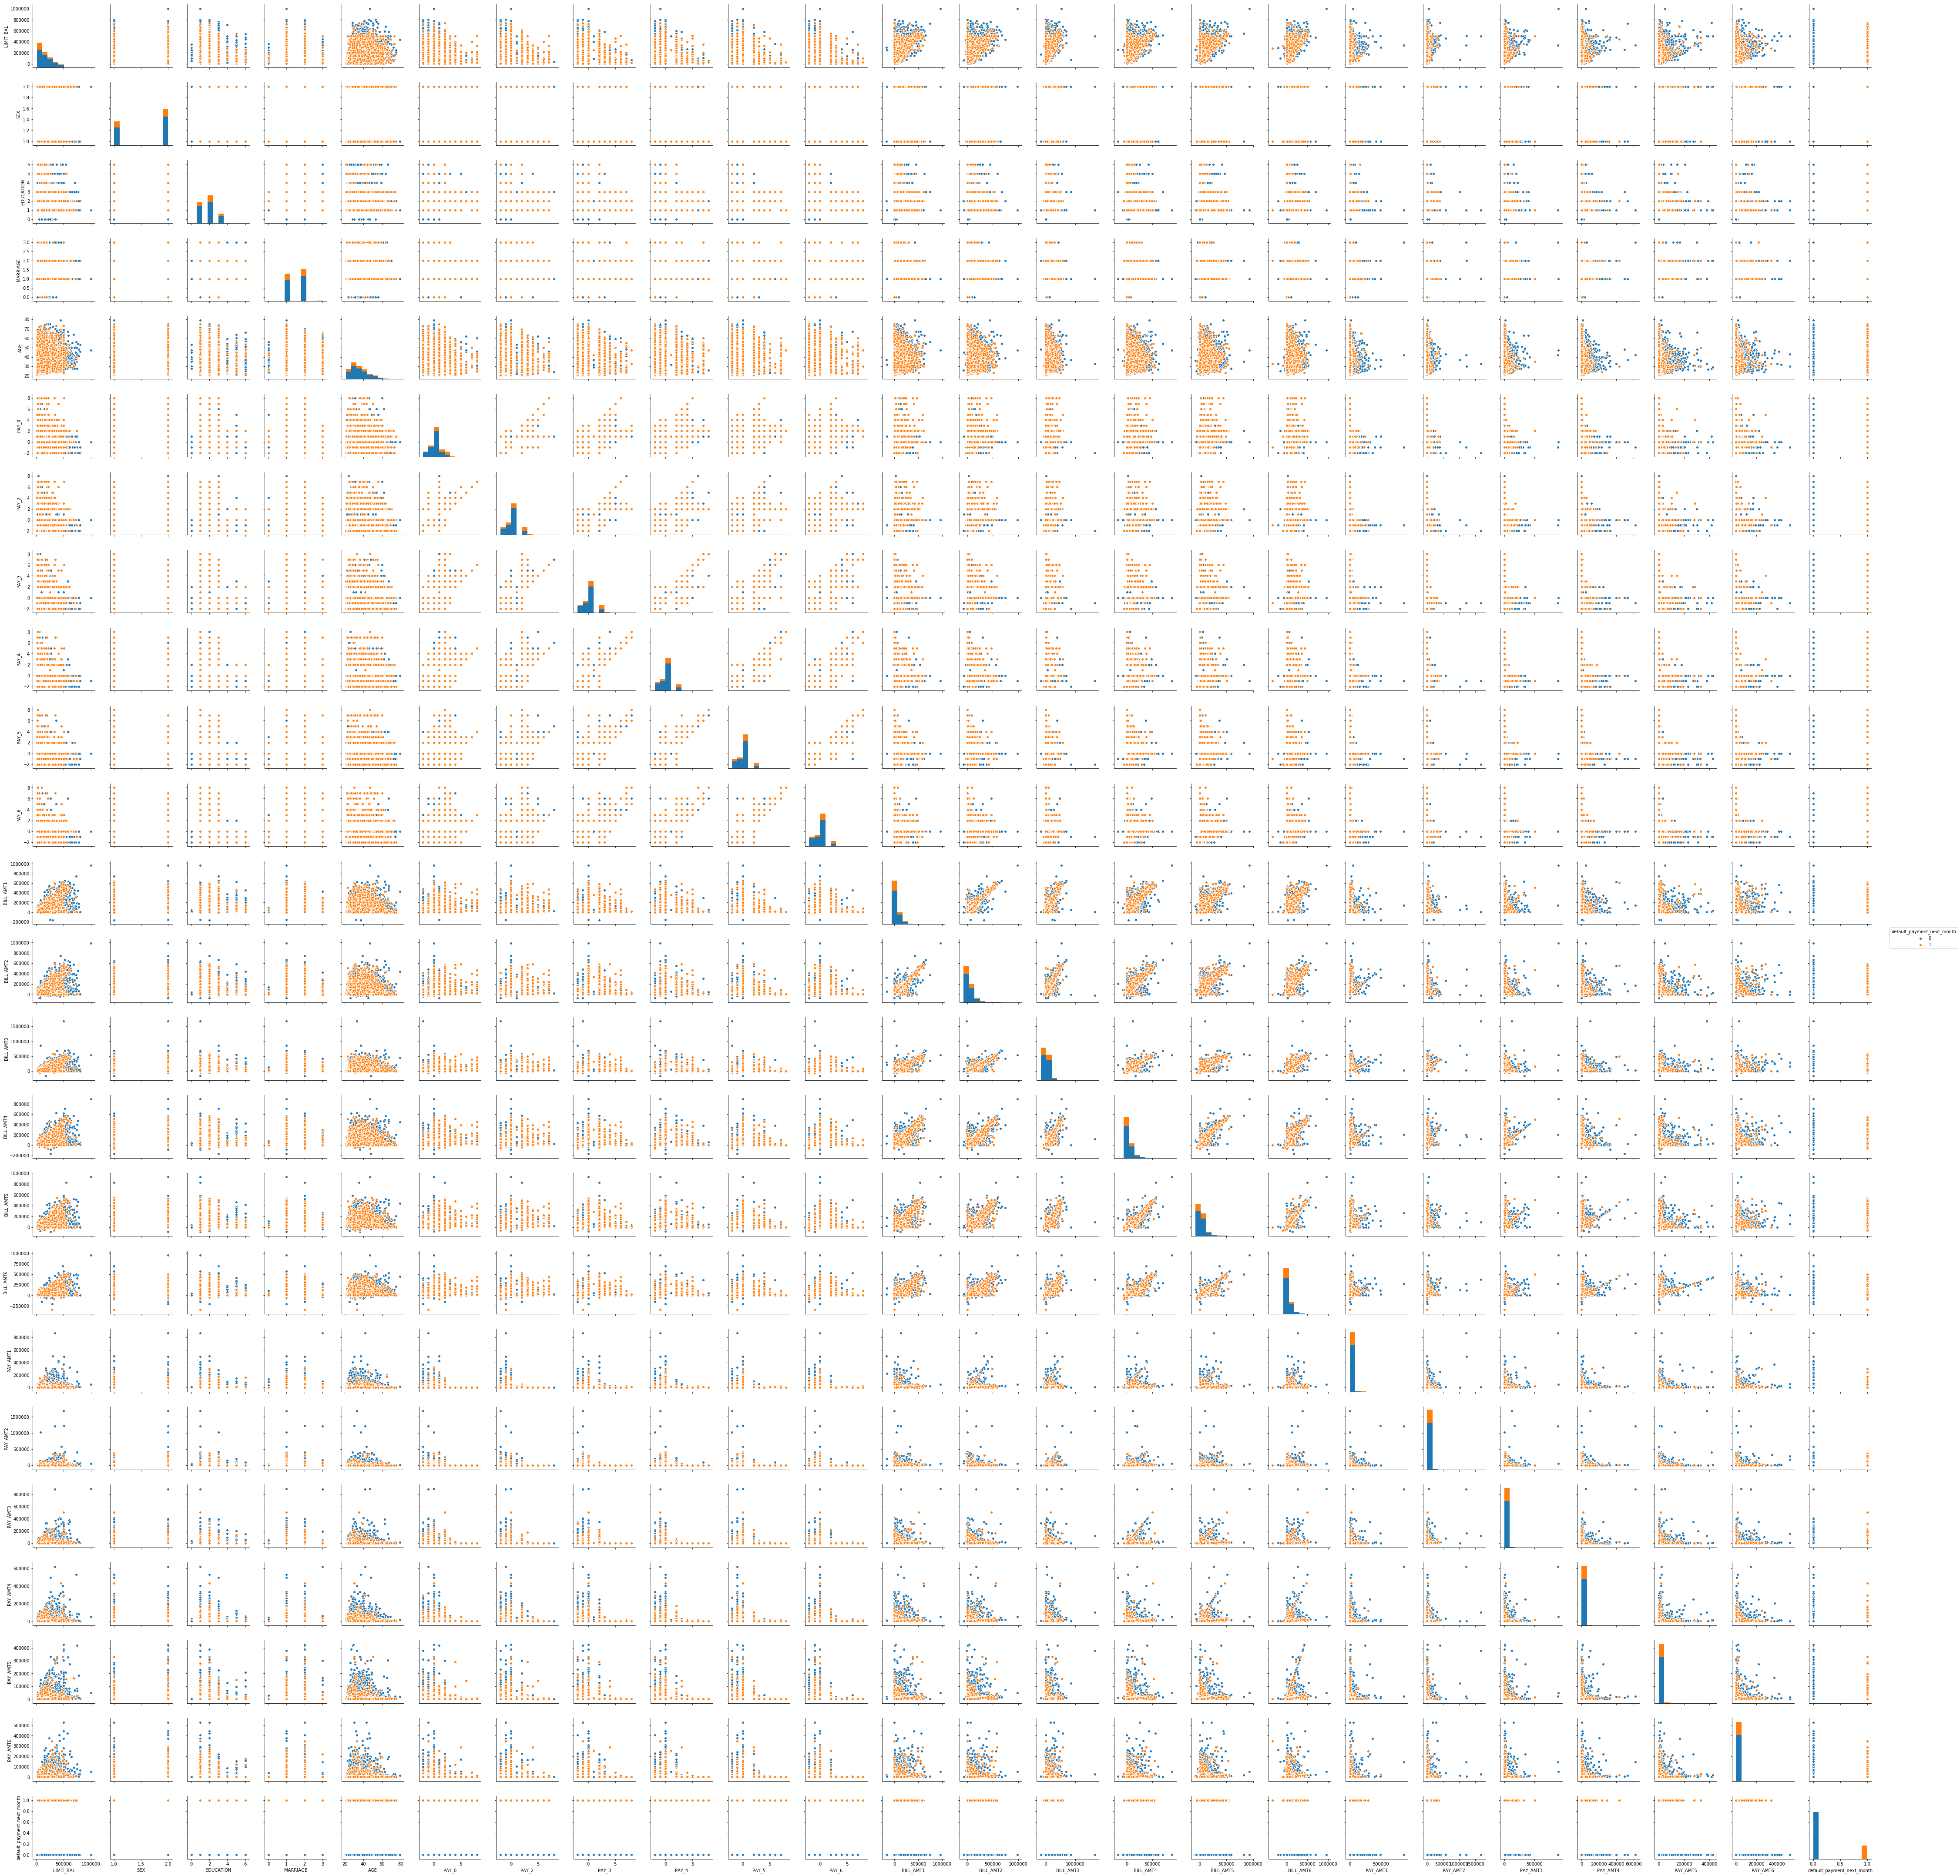

In [6]:
g = sns.pairplot(cc_raw, hue='default_payment_next_month')

In [8]:
fig = g.fig
fig.savefig('FinalProj_pairplot.png')

In [4]:
# with open('data/taiwan_cc/cc_pairplot.pickle', 'xb') as f:
#     pickle.dump(g, f)
    
# with open('data/taiwan_cc/cc_pairplot.pickle', 'rb') as f:
#     g = pickle.load(f)

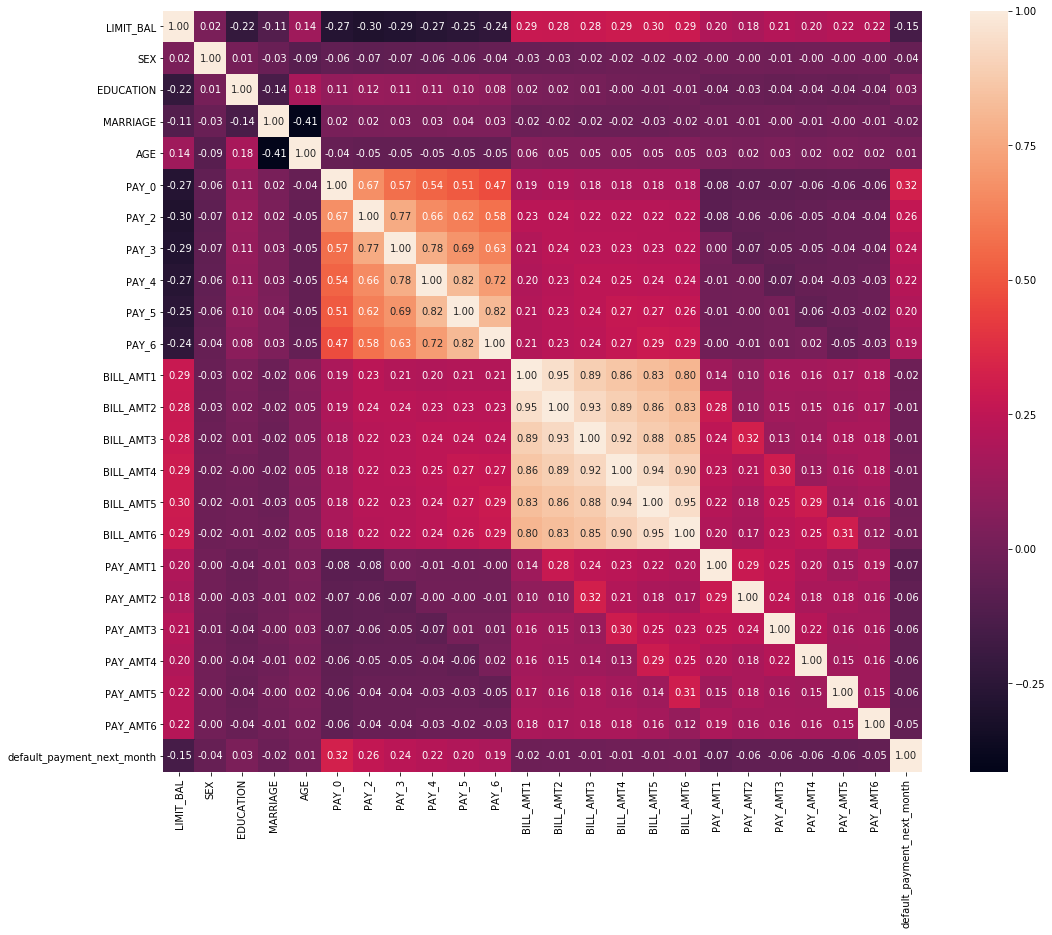

In [5]:
f, ax = plt.subplots(figsize=(17,14))
sns.heatmap(cc_raw.corr(), cbar=True, annot=True, fmt='.2f')

Looking at the correlation matrix above (represented as a heatmap), we see that 'PAY_0' is the feature with the strongest correlation to 'default_payment_next_month', but it only has a $0.32$ Pearson correlation coefficient, and there's a 

In [3]:
# This produces a rather attractive scatterplot 
# df:         a dataframe that contains featureA, featureB, and class_variable
# featureA:   a String representation of one of the columns in DF
# featureB:   a String representation of another of the columns in DF
# class_var:  a String representation of one the class labels column in DF
def feature_compare(df, featureA, featureB, class_var='default_payment_next_month'):
    g = sns.FacetGrid(data=df[[class_var, featureA, featureB]],hue=class_var,
                      hue_order=[0,1], aspect=1, size=5)
    fig = g.fig
    g.map(plt.scatter, featureA, featureB).add_legend()
    fig.suptitle(featureA + ' VS. ' + featureB)

In [4]:
cc_raw.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default_payment_next_month'],
      dtype='object')

In [5]:
cc_raw.describe()

LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667      1.603733      1.853133      1.551867     35.485500   
std     129747.661567      0.489129      0.790349      0.521970      9.217904   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.000000      3.000000     79.000000   

              PAY_0         PAY_2         PAY_3         PAY_4         PAY_5  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.016700     -0.133767     -0.166200     -0.220667     -0.266200   
std        1.123802      1.197186      1.196868      1.169139      1.133187   
min       -2.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        8.000000      8.000000      8.000000      8.000000      8.000000   

                  ...                  BILL_AMT4      BILL_AMT5  \
count             ...               30000.000000   30000.000000   
mean              ...               43262.948967   40311.400967   
std               ...               64332.856134   60797.155770   
min               ...             -170000.000000  -81334.000000   
25%               ...                2326.750000    1763.000000   
50%               ...               19052.000000   18104.500000   
75%               ...               54506.000000   50190.500000   
max               ...              891586.000000  927171.000000   

           BILL_AMT6       PAY_AMT1      PAY_AMT2      PAY_AMT3  \
count   30000.000000   30000.000000  3.000000e+04   30000.00000   
mean    38871.760400    5663.580500  5.921163e+03    5225.68150   
std     59554.107537   16563.280354  2.304087e+04   17606.96147   
min   -339603.000000       0.000000  0.000000e+00       0.00000   
25%      1256.000000    1000.000000  8.330000e+02     390.00000   
50%     17071.000000    2100.000000  2.009000e+03    1800.00000   
75%     49198.250000    5006.000000  5.000000e+03    4505.00000   
max    961664.000000  873552.000000  1.684259e+06  896040.00000   

            PAY_AMT4       PAY_AMT5       PAY_AMT6  default_payment_next_month  
count   30000.000000   30000.000000   30000.000000                30000.000000  
mean     4826.076867    4799.387633    5215.502567                    0.221200  
std     15666.159744   15278.305679   17777.465775                    0.415062  
min         0.000000       0.000000       0.000000                    0.000000  
25%       296.000000     252.500000     117.750000                    0.000000  
50%      1500.000000    1500.000000    1500.000000                    0.000000  
75%      4013.250000    4031.500000    4000.000000                    0.000000  
max    621000.000000  426529.000000  528666.000000                    1.000000  

[8 rows x 24 columns]

<function matplotlib.pyplot.tight_layout>

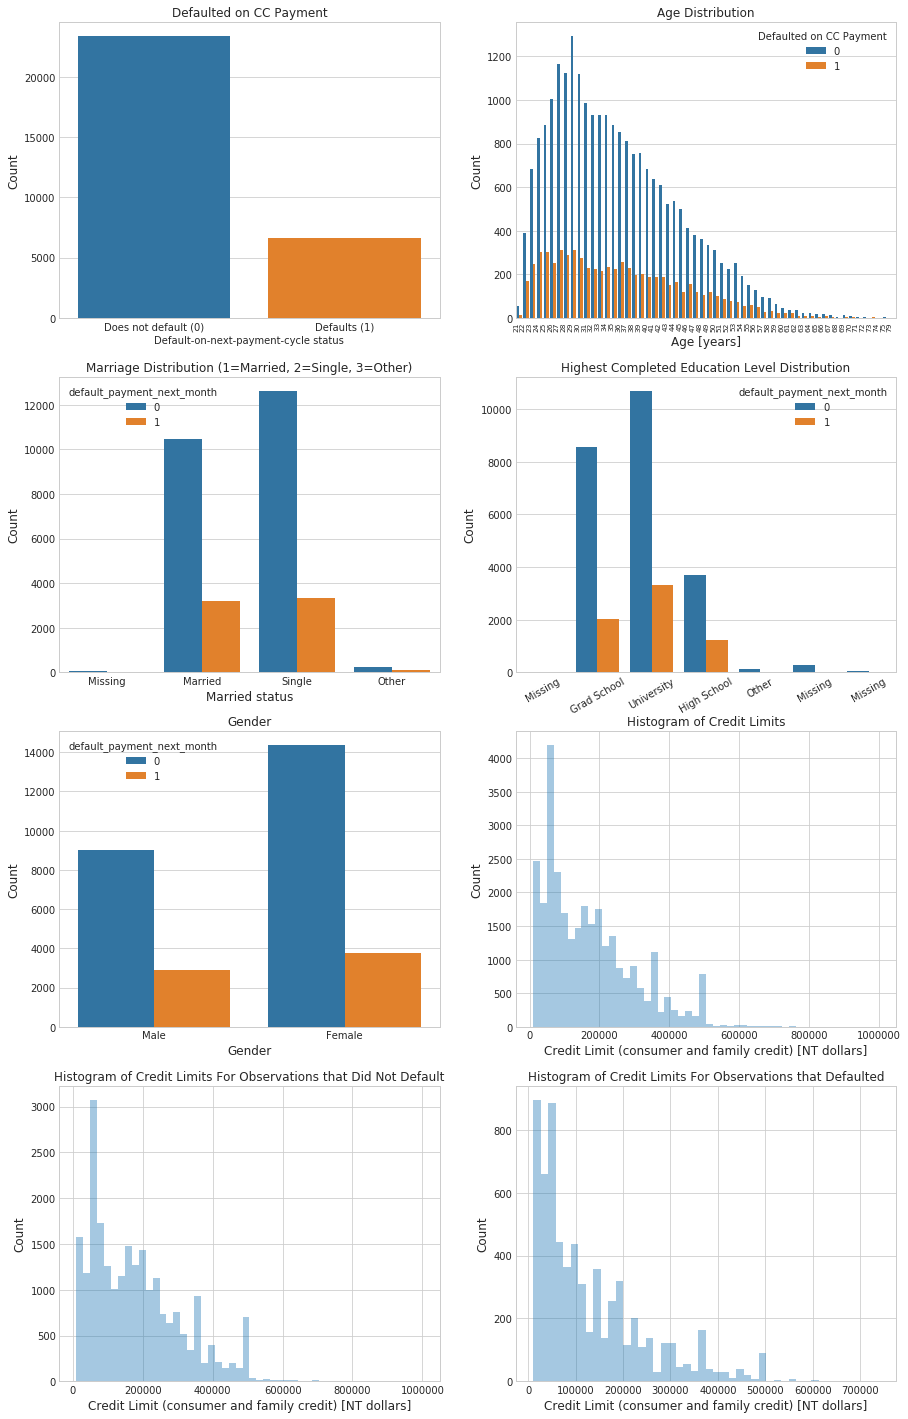

In [3]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(15,25))
    ax = ax.flatten()
#     fig.suptitle(title)
    sns.countplot(x='default_payment_next_month', data=cc_raw, ax=ax[0])
    ax[0].set_ylabel('Count', fontsize=12)
    ax[0].set_xticklabels(['Does not default (0)', 'Defaults (1)'])
    ax[0].set_xlabel('Default-on-next-payment-cycle status')
    ax[0].set_title('Defaulted on CC Payment')
    sns.countplot(x='AGE', data=cc_raw, hue='default_payment_next_month', ax=ax[1])
    ax[1].set_xlabel('Age [years]', fontsize=12)
    ax[1].set_ylabel('Count', fontsize=12)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha='right', fontsize=7.5)
    ax[1].legend(loc='upper right', title='Defaulted on CC Payment')
    ax[1].set_title('Age Distribution')
    sns.countplot(x='MARRIAGE', data=cc_raw, hue='default_payment_next_month', ax=ax[2])
    ax[2].set_xlabel('Married status', fontsize=12)
    ax[2].set_xticklabels(['Missing', 'Married', 'Single', 'Other'])
    ax[2].set_ylabel('Count', fontsize=12)
    ax[2].set_title('Marriage Distribution (1=Married, 2=Single, 3=Other)')
    sns.countplot(x='EDUCATION', data=cc_raw, hue='default_payment_next_month', ax=ax[3])
    ax[3].set_xlabel('', fontsize=12)
    ax[3].set_xticklabels(['Missing','Grad School','University','High School','Other','Missing','Missing'],
                         rotation=30)
    ax[3].set_ylabel('Count', fontsize=12)
    ax[3].set_title('Highest Completed Education Level Distribution') 
    
    sns.countplot(x='SEX', data=cc_raw, hue='default_payment_next_month', ax=ax[4])
    ax[4].set_xlabel('Gender', fontsize=12)
    ax[4].set_xticklabels(['Male', 'Female'])
    ax[4].set_ylabel('Count', fontsize=12)
    ax[4].set_title('Gender')
    # Not including a number of bins, distplot uses the Freedman-Diaconis rule by default
    sns.distplot(cc_raw['LIMIT_BAL'], norm_hist=False, kde=False, ax=ax[5])
    ax[5].set_xlabel('Credit Limit (consumer and family credit) [NT dollars]', fontsize=12)
    ax[5].set_ylabel('Count', fontsize=12)
    ax[5].set_title('Histogram of Credit Limits')
    sns.distplot(cc_raw['LIMIT_BAL'][cc_raw['default_payment_next_month']==0], 
                 norm_hist=False, kde=False, ax=ax[6])
    ax[6].set_xlabel('Credit Limit (consumer and family credit) [NT dollars]', fontsize=12)
    ax[6].set_ylabel('Count', fontsize=12)
    ax[6].set_title('Histogram of Credit Limits For Observations that Did Not Default')
    sns.distplot(cc_raw['LIMIT_BAL'][cc_raw['default_payment_next_month']==1], 
                 norm_hist=False, kde=False, ax=ax[7])
    ax[7].set_xlabel('Credit Limit (consumer and family credit) [NT dollars]', fontsize=12)
    ax[7].set_ylabel('Count', fontsize=12)
    ax[7].set_title('Histogram of Credit Limits For Observations that Defaulted')
plt.tight_layout

### Data Set Feature Descriptions

|--- Feature Name ---|-------- Feature Description --------|------------------  Defined Values  ------------------|
| :--------------: | --------------------: | :---------------- |
| $default\_payment\_next\_month$ | Binary Target Feature indicating a Default on Payment | $0=\text{No Default}$ |
|  |  | $1=\text{Default}$ |
| $LIMIT\_BAL$ | Ammount of available consumer and family credit [NT \$] | $LIMIT\_BAL \geq 0$ |
| $SEX$ | Gender  | $1=\text{Male}$ |
|  |  | $2=\text{Female}$ |
| $EDUCATION$ | Highest completed education level | $1=\text{Grad School}$ |
|  |  | $2=\text{University}$ |
|  |  | $3=\text{High School}$ |
|  |  | $4=\text{Other}$ |
| $MARRIAGE$ | Marital Status | $1=\text{Married}$ |
|  |  | $2=\text{Single}$ |
|  |  | $3=\text{Other}$ |
| $AGE$ | Age | $AGE \geq 0$ |
| $PAY\_x$ | Number of months delinquent 'x' months ago | $-1=\text{no delinquency}$ |
|  |  | $ 1\text{ up to }N=\text{Delinquent 1 to N months}$ |
| $BILL\_AMT\_x$ | Ammount of bill statement 'x' months ago [NT \$] | Any real number (negative values are credits) |
| $PAY\_AMT\_x$ | Amount paid 'x' months ago [NT \$] | $PAY\_AMT\_x \geq 0$ |

### Exploratory Data Analysis

Per the data descriptions, the $MARRIAGE$ feature should only include values 1, 2, and 3, so I will treat the 0s observed in the data as missing values. Per the count below, 54 of 30000 observations (or $0.18\%$) have a missing value for $MARRIAGE$. 

Also, $EDUCATION$ only includes values from $1$ to $4$, but values of $0$, $5$, and $6$ were observed in the data. They will also be treated as missing variables. Per the count below, 345 of 30000 observations (or $1.15\%$) have a missing value for $EDUCATION$. 

As the distribution of target labels is very imbalanced , I'll use SMOTE 

## Preprocessing

As the fraction of missing values is very small, I will drop these entries with illegal values. I explored using Multiple Imputation from Chained Equations$^{micebib}$ (**MICE**), but I ran into some implementation difficulties while trying to break apart the imputation process in my manual cross validation implementation so that the imputer could be trained by the training data and not taint the test data. Time permitting, I'll return to this.

In [6]:
cc_no_NAs = cc_raw
marriage_0s = cc_no_NAs['MARRIAGE'][cc_no_NAs['MARRIAGE'] == 0]
edu_NAs = cc_no_NAs['EDUCATION'][cc_no_NAs['EDUCATION'].isin([0,5,6])]
print('There are {} records in the data set where MARRIAGE == 0'.format(len(marriage_0s)))
print('There are {} records in the data set where EDUCATION != a defined value (ie [1,2,3,4])'
      .format(len(edu_NAs)))
cc_no_NAs.loc[marriage_0s.index, 'MARRIAGE'] = None
cc_no_NAs.loc[edu_NAs.index, 'EDUCATION'] = None
cc_no_NAs.dropna(axis=0, inplace=True)

There are 54 records in the data set where MARRIAGE == 0
There are 345 records in the data set where EDUCATION != a defined value (ie [1,2,3,4])


In [8]:
missing_data = cc_cats.columns[cc_cats.isnull().any()].tolist()
# msno.matrix(cc_cats[missing_data])
cc_cats_index = cc_cats.index
cc_cats_cols = cc_cats.columns
missing_data
# msno.matrix??

[]

In [9]:
# cc_df_prepd = pd.DataFrame(data=cc_cats, columns=cc_cats, index=cc_raw_index)
cc_classes = cc_cats['default_payment_next_month']
cc_cats.drop('default_payment_next_month', axis=1, inplace=True)
display(cc_classes.head(5))
display(cc_cats.head(5))
print('The data df, cc_cats, has shape {}'.format(cc_cats.shape))

ID
1    1
2    1
3    0
4    0
5    0
Name: default_payment_next_month, dtype: int64

LIMIT_BAL  AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
ID                                                                          
1       20000   24       3913       3102        689          0          0   
2      120000   26       2682       1725       2682       3272       3455   
3       90000   34      29239      14027      13559      14331      14948   
4       50000   37      46990      48233      49291      28314      28959   
5       50000   57       8617       5670      35835      20940      19146   

    BILL_AMT6  PAY_AMT1  PAY_AMT2   ...     PAY_6_-2  PAY_6_-1  PAY_6_0  \
ID                                  ...                                   
1           0         0       689   ...            1         0        0   
2        3261         0      1000   ...            0         0        0   
3       15549      1518      1500   ...            0         0        1   
4       29547      2000      2019   ...            0         0        1   
5       19131      2000     36681   ...            0         0        1   

    PAY_6_2  PAY_6_3  PAY_6_4  PAY_6_5  PAY_6_6  PAY_6_7  PAY_6_8  
ID                                                                 
1         0        0        0        0        0        0        0  
2         1        0        0        0        0        0        0  
3         0        0        0        0        0        0        0  
4         0        0        0        0        0        0        0  
5         0        0        0        0        0        0        0  

[5 rows x 87 columns]

The data df, cc_cats, has shape (29601, 87)


In addition to the issue of missing values (which we just handled through imputation), the class labels are severely imbalanced and we'll want to do something to balance them, however, we don't want to apply SMOTE or ADASYN across the entire dataset as it will imprint information from training sets onto testing sets, which destroys the perfect partition between training and testing sets, so we'll have to build it into a loop. Also, we need to preserve the categorical natures of features like $MARRIAGE$, $SEX$, and $EDUCATION$, so that they're not treated as continuous variables when we balance classes.

In [8]:
_map = sns.choose_colorbrewer_palette('sequential', as_cmap=True)

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Purples', 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuRd', 'RdPu', 'YlGn', 'PuBuGn', 'YlGnBu', 'YlOrBr', 'YlOrRd'), value='Greys'), IntSlider(value=10, description='n', max=18, min=2), FloatSlider(value=1.0, description='desat', max=1.0), Dropdown(description='variant', options=('regular', 'reverse', 'dark'), value='regular'), Output()), _dom_classes=('widget-interact',))

In [120]:
#helper
# avg_cfn = np.mean(cfns, axis=0).astype(int)
g_cmap = sns.light_palette('seagreen', n_colors=10, as_cmap=True)
def confusion_mat_plotter(ax, cfn_matrix, class_labels, title, cmap=g_cmap):
#     print(cfn_matrix)
    sns.heatmap(cfn_matrix.T, square=True, annot=True, fmt='d', cbar=True, 
            xticklabels=class_labels, yticklabels=class_labels, ax=ax, cmap=g_cmap)
    ax.set_xlabel('True Class')
    ax.set_ylabel('Predicted Class')
    ax.set_title('Confusion Matrix {}'.format(title))

Scratchwork: 

$$\text{F-measure} = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{sensitivity}}} = \frac{TP}{TP + \frac{FN + FP}{2}}$$

In [14]:
#helper
def metric_printer(TN, FN, FP, TP, clf_name, data_desc=''):
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    precision = TP / (TP + FP)
    fpr = FP / (TN + FP)
    total_acc = (TP + TN) / (FP + FN + TP + TN)
    f_meas = TP / (TP + ( (FN + FP) / 2 ) )
    print('Metrics for the best ' + data_desc + ' trained ' + clf_name)
    print('- Overall Accuracy: {:22.4f}'.format(total_acc))
    print('- True Positive Rate (sensitivity): {:6.4f}'.format(sensitivity))
    print('- True Negative Rate (specificity): {:6.4f}'.format(specificity))
    print('- Precision (recall): {:20.4f}'.format(precision))
    print('- False Positive Rate: {:19.4f}'.format(fpr))
    print('- F-measure: {:29.4f}'.format(f_meas))

In [15]:
def plot_precision_recall_vs_threshold(ax_, precisions, recalls, thresholds):
    with plt.style.context('seaborn-whitegrid'):
        ax.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=1)
        ax.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=1)
        ax.set_xlabel("Threshold", fontsize=16)
        ax.legend(loc="upper left", fontsize=16)
        ax.set_ylim([0, 1])
    return ax

In [128]:
# 
def roc_plotter(ax_, fprs_, tprs_, threshs_, title):
    tpr_set = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for i in range(len(fprs_)):
        ax_.plot(fprs_[i], tprs_[i], lw=1, alpha=0.3)
        tpr_set.append(interp(mean_fpr, fprs_[i], tprs_[i]))
        tpr_set[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    mean_tpr = np.mean(tpr_set, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    std_tpr = np.std(tpr_set, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax_.plot(mean_fpr, mean_tpr, color='b',
            label='Mean ROC (AUC = {:0.2f} $\pm$ {:0.2f})'
               .format(mean_auc, std_auc), lw=2, alpha=0.8)
    ax_.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', 
                     alpha=.2, label='$\pm$ 1 std. dev.')
    ax_.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', 
               label='Random', alpha=.8)
    ax_.legend(loc='best', fancybox=True, framealpha=0.4)
#     ax[1].legend(loc=(1.03, 0), fancybox=True, framealpha=0.4)
    ax_.set_title('{} ROC Curve'.format(title))
    ax_.set_ylabel('True Positive Rate')
    ax_.set_xlabel('False Positive Rate')
    ax_.set_xlim([0.0,1.0])
    ax_.set_ylim([0.0,1.0])

In [16]:
#helper
def param_heat_mapper(ax_, df_, ind_col, val_col, col_col, base_clfname, cmap=g_cmap):
    logit_piv = df_.pivot(index=ind_col, values=val_col, columns=col_col)
    title_ = base_clfname + ' , Params: ' + ind_col + ' and ' + col_col
    with plt.style.context('seaborn-whitegrid'):
        sns.heatmap(logit_piv, linewidths=0.0, annot=True, fmt='0.4f', ax=ax_, cmap=cmap, robust=True)
        ax_.set_title(title_, fontsize=16)
        ax_.set_xlabel('Param: ' + col_col, fontsize=16)
        ax_.set_ylabel('Param: ' + ind_col, fontsize=16)

In [9]:
#helper
# This executes a simple fit-predict-evaluate routine with a single data split.
# classifier:   a classifier model that conforms to sklearns regular classifier interface
# data/class_train/test: array-like containers holding corresponding data and class labels
def clf_evaluation(classifier, data_train_, data_test_, class_train_, class_test_, pred_, thresh=0.5):
    classifier.fit(data_train_, class_train_)
    if pred_ == 'predict_proba':
        print('predict_proba!')
        clf_probas = classifier.predict_proba(data_test_)
        clf_pred = (clf_probas > thresh).astype(int)
        print((clf_probas > thresh))
    elif pred_ == 'predict':
        clf_pred = classifier.predict(data_test_)
    print('clf_pred.flatten(): ' + str(clf_pred.flatten()))
    print('class_test_: ' + str(class_test_))
#     clf_pred = classifier.predict(data_test_)
    clf_acc = accuracy_score(class_test_, (clf_pred > thresh).astype(int).flatten())
    clf_rec = recall_score(class_test_, clf_pred)
    clf_pre = precision_score(class_test_, clf_pred)
    clf_cfn = confusion_matrix(class_test_, clf_pred)
#     pdb.set_trace()
    return clf_acc, clf_rec, clf_pre, clf_cfn, clf_pred

# TODO: build a cumulative ROC  curve
def manual_crossvalidator(clf_, df_, classes_, predictor, printIt=True, n_trials=30, seed=1234, thresh=0.5):
    rng = np.random.RandomState(seed)
    random_seeds = rng.randint(low=0, high=99999, size=n_trials)
    sm = SMOTE(kind='regular')
    recall_ = []; precision_ = []; accuracy_ = []; cfn_mats_ = []
    preds_ = []; fprs_ = []; tprs_ = []
    for i in range(n_trials):
        d_train, d_test, class_train, class_test = \
                train_test_split(df_, classes_, random_state=random_seeds[i])
        d_train_sm, class_train_sm = sm.fit_sample(d_train, class_train)
        d_test_sm, class_test_sm = sm.fit_sample(d_test, class_test)
        rec, pre, acc, cfn, pred = clf_evaluation(clf_, d_train_sm, d_test_sm,\
                                            class_train_sm, class_test_sm, predictor)
        recall_.append(rec); precision_.append(pre); accuracy_.append(acc)
        np.append(cfn_mats_, cfn)
        np.append(preds_, pred)
        print('class_test_sm: '+ str(class_test_sm))
        print('class_test_sm.shape: '+ str(class_test_sm.shape))
        print('pred: ' + str(pred))
        print('preds_: '+ str(preds_))
#         print('preds_.shape: '+ str(preds_.shape))
        fpr, tpr, _ = roc_curve(class_test_sm, preds_[:, 1])
        fprs.append(fpr); tprs.append(tpr)
    with plt.style.context('seaborn-whitegrid'):
        fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
        roc_builder(fprs, tprs, ax[1])
    return recall_, precision_, accuracy_, cfn_mats_

# TODO: BUILD THIS FROM THE ROC_exploration FILE
# Adapted from https://goo.gl/UF1LJ2
def roc_builder(fprs_, tprs_, ax_):
    aucs_ = []
    tpr_spread_ = []
    mean_fpr = np.linspace(0, 1, 100)
    i=0
    for fpr_, tpr_ in zip(fprs_, tprs_):
        tpr_spread_.append(interp())
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr_, tpr_)
        aucs.append(roc_auc)
        label_ = 'ROC fold {:0.0d} (AUC = {:0.3f})'.format(i, roc_auc)
        i += 1
        ax_.plot(fpr_, tpr_, lw=0.5, alpha=0.3, label=label_)
    ax.plot([0,1],[0,1], linestyle='--', lw=1, color=-'r', label='Random Clf', alpha=0.8)
        
    

In [17]:
# def evaluator(clf_, data_, labels_,  clf_type, cv_runs_=30,
#               scale_data=False, seed=1234, debugger = False):
def evaluator(clf_, data_, labels_,  clf_type, cv_runs_=30,
              seed=1234, debugger = False, plot_thresh=False):
    tprs = []
    aucs = []
    cfns = np.zeros((2,2), dtype=int)
    mean_fpr = np.linspace(0, 1, 100)
    rng = np.random.RandomState(seed)
    random_seeds = rng.randint(low=0, high=99999, size=cv_runs_)
#     robust_scaler = RobustScaler()
    with plt.style.context('seaborn-whitegrid'):
        fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(14,7))
    if plot_thresh:
        ax_thresh = ax[1].twinx()
        ax_thresh.set_xlim([0,1])
        ax_thresh.set_ylim([0,1])
        ax_thresh_y = ax[1].twiny()
        ax_thresh_y.set_xlabel('Threshold: True Positive Rate', color='r',
                              fontsize=8)
    
    for i in range(cv_runs_):
        d_train, d_test, cls_train, cls_test = \
                    train_test_split(data_, labels_, random_state=random_seeds[i])
        d_train_sm, cls_train_sm = sm.fit_sample(d_train, cls_train)
        d_test_sm, cls_test_sm = sm.fit_sample(d_test, cls_test)
#         if scale_data:
#             d_train_sm = robust_scaler.fit_transform(d_train_sm)
#             d_test_sm = robust_scaler.transform(d_test_sm)
        probas_ = clf_.fit(d_train_sm, cls_train_sm).predict_proba(d_test_sm)
        preds_ = clf_.predict(d_test_sm)
        cfn_ = confusion_matrix(cls_test_sm, preds_, [0,1])
        cfns = cfns + cfn_
        if debugger:
            print('d_train.shape: ' + str(d_train.shape))
            print('cls_train.shape: ' + str(cls_train.shape))
            print('d_test.shape: ' + str(d_test.shape))
            print('cls_test.shape: ' + str(cls_test.shape))
            print('d_train_sm.shape: ' + str(d_train_sm.shape))
            print('cls_train_sm.shape: ' + str(cls_train_sm.shape))
            print('d_test_sm.shape: ' + str(d_test_sm.shape))
            print('cls_test_sm.shape: ' + str(cls_test_sm.shape))
            print('cc_test_sm.shape: ' + str(cc_test_sm.shape))
            print('probas_.shape: ' + str(probas_.shape))
            print('probas_[:, 1].shape: ' + str(probas_[:, 1].shape))
        fpr, tpr, thresholds = roc_curve(cls_test_sm, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0 
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
#         l_label = 'ROC for cv run {:d} (AUC = {:0.2f})'.format(i, roc_auc)
        ax[1].plot(fpr, tpr, lw=1, alpha=0.3)
        if plot_thresh:
            ax_thresh.plot(tpr[1:], thresholds[1:], linestyle='dashed', alpha=0.3, lw=0.7)
    
    # Plotting the average Confusion Matrix
    cfns = cfns//i
    cfn_title = 'Averaged Confusion Matrix for {} Clf'.format(clf_type)
    confusion_mat_plotter(ax[0], cfns, [0,1], cfn_title)
    
    # Plotting the error bars on the ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax[1].plot(mean_fpr, mean_tpr, color='b',
            label='Mean ROC (AUC = {:0.2f} $\pm$ {:0.2f})'
               .format(mean_auc, std_auc), lw=2, alpha=0.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax[1].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', 
                     alpha=.2, label='$\pm$ 1 std. dev.')
    ax[1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', 
               label='Random', alpha=.8)
    ax[1].legend(loc='best', fancybox=True, framealpha=0.4)
#     ax[1].legend(loc=(1.03, 0), fancybox=True, framealpha=0.4)
    ax[1].set_title('{} ROC Curve'.format(clf_type), y=1.08)
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_xlim([0.0,1.0])
    ax[1].set_ylim([0.0,1.0])
    if plot_thresh:
        ax_thresh.set_ylabel('Threshold', color='r')

In [9]:
cc_cats.head(5)

NameError: name 'cc_cats' is not defined

In [10]:
from imblearn.over_sampling import SMOTE, ADASYN
# sm = SMOTE(kind='regular')
# c, r = train10k_labels.shape
sm = SMOTE(kind='regular')
cc_data_cols = cc_cats.columns
class_col = cc_classes.name
cc_train, cc_test, class_train, class_test = train_test_split(cc_cats,
                                                              cc_classes,
                                                              test_size=0.34,
                                                              random_state=123)
cc_train_sm, class_train_sm = sm.fit_sample(cc_train, class_train)
cc_test_sm, class_test_sm = sm.fit_sample(cc_test, class_test)
cc_train_sm = pd.DataFrame(cc_train_sm, columns=cc_data_cols)
class_train_sm = pd.Series(class_train_sm, name=class_col)
cc_test_sm = pd.DataFrame(cc_test_sm, columns=cc_data_cols)
class_test_sm = pd.DataFrame(class_test_sm, columns=[class_col])
# cc_cats_sm, cc_classes_sm = sm.fit_sample(cc_cats, cc_classes)
# cc_cats_sm = pd.DataFrame(cc_cats_sm, columns=cc_data_cols)
# cc_classes_sm = pd.Series(cc_classes_sm, name=class_col)

NameError: name 'cc_cats' is not defined

In [11]:
data_ = cc_train_sm
data_['default_payment_next_month'] = class_train_sm
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(5,5))
    sns.countplot(x='default_payment_next_month', data=data_, ax=ax)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xticklabels(['Does not default (0)', 'Defaults (1)'])
    ax.set_xlabel('Default-on-next-payment-cycle status')
    ax.set_title('Defaulted on CC Payment')

NameError: name 'cc_train_sm' is not defined

In [26]:
logit_pipe_clf = imbPipeline([
    ('smote', SMOTE(random_state=nb_seed)),
    ('logit_clf', LogisticRegression())
])

In [34]:
logit_param = [
    {'logit_clf__penalty': ['l2'],
     'logit_clf__solver': ['sag', 'lbfgs', 'newton-cg'],
     'logit_clf__C': [0.01, 0.1, 1, 10, 35, 50],
     'logit_clf__max_iter': [100]
    },
    {'logit_clf__penalty': ['l1'],
     'logit_clf__solver': ['saga', 'liblinear'],
     'logit_clf__C': [0.01, 0.1, 1, 10, 35, 50],
     'logit_clf__max_iter': [100]
    }
]

In [59]:
from sklearn.metrics import log_loss
k_cv = StratifiedKFold(n_splits=5, random_state=nb_seed)
logit_clf_grid = GridSearchCV(logit_pipe_clf, logit_param, verbose=9, cv=k_cv,
                              n_jobs=-1, return_train_score=True, scoring='recall_score')

%time logit_clf_grid.fit(cc_cats, cc_classes)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  6.8min finished


Wall time: 6min 48s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('smote', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=1234, ratio='auto', svm_estimator=None)), ('logit_clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'logit_clf__penalty': ['l2'], 'logit_clf__C': [0.01, 0.1, 1, 10, 35, 50], 'logit_clf__solver': ['sag', 'lbfgs', 'newton-cg'], 'logit_clf__max_iter': [100]}, {'logit_clf__penalty': ['l1'], 'logit_clf__C': [0.01, 0.1, 1, 10, 35, 50], 'logit_clf__solver': ['saga', 'liblinear'], 'logit_clf__max_iter': [100]}],
       pre_dispatch='2*n_

In [60]:
logit_sm_dict = {'mean_test_acc': logit_clf_grid.cv_results_['mean_test_score'], 
             'mean_train_acc': logit_clf_grid.cv_results_['mean_train_score'], 
             'C': logit_clf_grid.cv_results_['param_logit_clf__C'].data,
             'penalty': logit_clf_grid.cv_results_['param_logit_clf__penalty'].data,
             'solver': logit_clf_grid.cv_results_['param_logit_clf__solver'].data
           }
logit_sm_df = pd.DataFrame(logit_sm_dict)

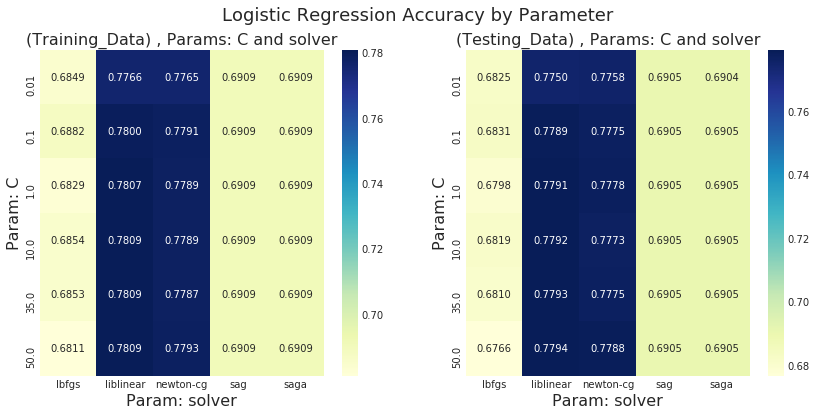

In [61]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(14,6))
    fig.suptitle('Logistic Regression Accuracy by Parameter', fontsize=18)
    ax = ax.flatten()
    param_heat_mapper(ax[0], logit_sm_df, 'C', 'mean_train_acc', 'solver',
                      '(Training_Data)', cmap=g_cmap)
    param_heat_mapper(ax[1], logit_sm_df, 'C', 'mean_test_acc', 'solver',
                      '(Testing_Data)', cmap=g_cmap)

In [27]:
logit_param_2 = [
    {'logit_clf__penalty': ['l2'],
     'logit_clf__solver': ['newton-cg'],
     'logit_clf__C': [0.01,1, 10, 100, 1000],
     'logit_clf__max_iter': [100]
    },
    {'logit_clf__penalty': ['l1'],
     'logit_clf__solver': ['liblinear'],
     'logit_clf__C': [0.01,1, 10, 100, 1000],
     'logit_clf__max_iter': [100]
    }
]

In [28]:
k_cv = StratifiedKFold(n_splits=5, random_state=nb_seed)
logit_clf_grid = GridSearchCV(logit_pipe_clf, logit_param_2, verbose=9, cv=k_cv,
                              n_jobs=-1, return_train_score=True, scoring='recall_score')

%time logit_clf_grid.fit(cc_cats, cc_classes)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  3.8min remaining:   49.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  3.9min remaining:   15.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.0min finished


Wall time: 4min 4s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('smote', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=1234, ratio='auto', svm_estimator=None)), ('logit_clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'logit_clf__solver': ['newton-cg'], 'logit_clf__C': [0.01, 1, 10, 100, 1000], 'logit_clf__penalty': ['l2'], 'logit_clf__max_iter': [100]}, {'logit_clf__solver': ['liblinear'], 'logit_clf__C': [0.01, 1, 10, 100, 1000], 'logit_clf__penalty': ['l1'], 'logit_clf__max_iter': [100]}],
       pre_dispatch='2*n_jobs', refit=True, return_tr

In [30]:
logit_sm_dict = {'mean_test_acc': logit_clf_grid.cv_results_['mean_test_score'], 
             'mean_train_acc': logit_clf_grid.cv_results_['mean_train_score'], 
             'C': logit_clf_grid.cv_results_['param_logit_clf__C'].data,
             'penalty': logit_clf_grid.cv_results_['param_logit_clf__penalty'].data,
             'solver': logit_clf_grid.cv_results_['param_logit_clf__solver'].data
           }
logit_sm_df = pd.DataFrame(logit_sm_dict)

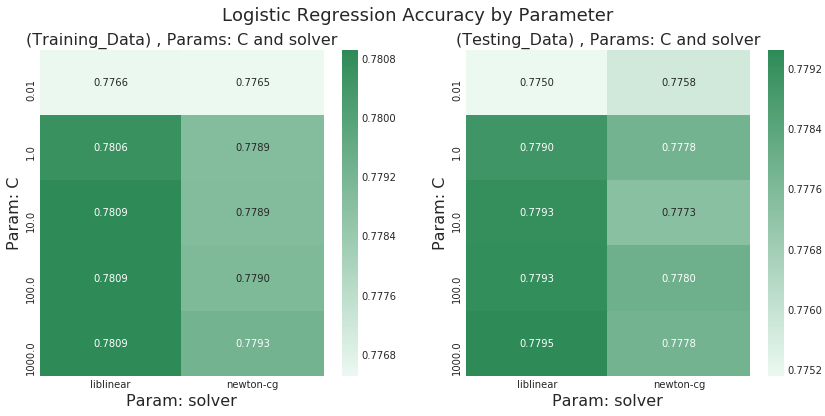

In [49]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(14,6))
    fig.suptitle('Logistic Regression Accuracy by Parameter', fontsize=18)
    ax = ax.flatten()
    param_heat_mapper(ax[0], logit_sm_df, 'C', 'mean_train_acc', 'solver',
                      '(Training_Data)', cmap=g_cmap)
    param_heat_mapper(ax[1], logit_sm_df, 'C', 'mean_test_acc', 'solver',
                      '(Testing_Data)', cmap=g_cmap)

In [41]:
logit_clf_grid.best_params_

{'logit_clf__C': 1000,
 'logit_clf__max_iter': 100,
 'logit_clf__penalty': 'l1',
 'logit_clf__solver': 'liblinear'}

### Logit Classifier with SMOTE and StandardScaler

In [17]:
logit_sm_ss_pipe_clf = imbPipeline([
    ('smote', SMOTE(random_state=nb_seed)),
    ('scaler', StandardScaler()),
    ('logit_clf', LogisticRegression())
])

In [26]:
logit_param = [
    {'logit_clf__penalty': ['l2'],
     'logit_clf__solver': ['sag', 'lbfgs', 'newton-cg'],
     'logit_clf__C': [1e-05, 1e-04, 1e-03, 0.01, 0.1, 0.5],
     'logit_clf__max_iter': [100]
    },
    {'logit_clf__penalty': ['l1'],
     'logit_clf__solver': ['saga', 'liblinear'],
     'logit_clf__C': [1e-05, 1e-04, 1e-03, 0.01, 0.1, 0.5],
     'logit_clf__max_iter': [100]
    }
]

In [27]:
k_cv = StratifiedKFold(n_splits=5, random_state=nb_seed)
logit_sm_ss_clf_grid = GridSearchCV(logit_sm_ss_pipe_clf, logit_param, verbose=9, cv=k_cv,
                              n_jobs=-1, return_train_score=True, scoring='recall_score')

%time logit_sm_ss_clf_grid.fit(cc_cats, cc_classes)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.3min finished


Wall time: 3min 18s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('smote', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=1234, ratio='auto', svm_estimator=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit_clf', LogisticRegression(C=1.0, class_weight=None, dua...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'logit_clf__solver': ['sag', 'lbfgs', 'newton-cg'], 'logit_clf__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5], 'logit_clf__penalty': ['l2'], 'logit_clf__max_iter': [100]}, {'logit_clf__solver': ['saga', 'liblinear'], 'logit_clf__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5], 'logit_clf__penalty': ['l1'], 'logit_clf__max_iter': [100]}],
       pre_dispatch='2*n_jobs', refit=True, re

In [28]:
grid_clf = logit_sm_ss_clf_grid
logit_sm_ss_dict = {'mean_test_acc': grid_clf.cv_results_['mean_test_score'], 
             'mean_train_acc': grid_clf.cv_results_['mean_train_score'], 
             'C': grid_clf.cv_results_['param_logit_clf__C'].data,
             'penalty': grid_clf.cv_results_['param_logit_clf__penalty'].data,
             'solver': grid_clf.cv_results_['param_logit_clf__solver'].data
           }
logit_sm_ss_df = pd.DataFrame(logit_sm_ss_dict)

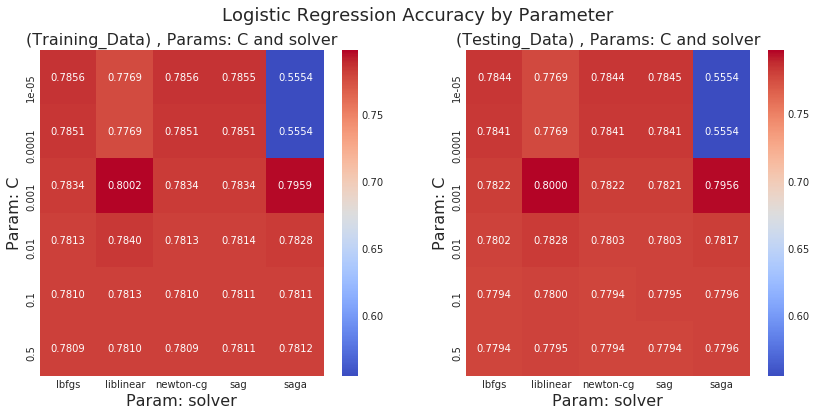

In [35]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(14,6))
    fig.suptitle('Logistic Regression Accuracy by Parameter', fontsize=18)
    ax = ax.flatten()
    param_heat_mapper(ax[0], logit_sm_ss_df, 'C', 'mean_train_acc', 'solver',
                      '(Training_Data)', cmap='coolwarm')
    param_heat_mapper(ax[1], logit_sm_ss_df, 'C', 'mean_test_acc', 'solver',
                      '(Testing_Data)', cmap='coolwarm')

In [50]:
logit_sm_ss_clf_grid.best_params_

{'logit_clf__C': 0.001,
 'logit_clf__max_iter': 100,
 'logit_clf__penalty': 'l1',
 'logit_clf__solver': 'liblinear'}

In [93]:
best_logit_sm_ss_pipe_clf = imbPipeline([
    ('smote', SMOTE(random_state=nb_seed)),
    ('scaler', StandardScaler()),
    ('logit_clf', LogisticRegression(C=0.001, max_iter=100,
                                     penalty='l1', solver='liblinear'))
])

In [46]:
type(cc_classes)

pandas.core.series.Series

In [113]:
# plt.rcParams['axes.color_cycle'] = ['#99d8c9','#fdbb84','#66c2a4','#fc8d59','#41ae76','#ef6548',
#                                     '#238b45','#d7301f','#006d2c','#b30000','#00441b','#7f0000']
#     with plt.style.context('seaborn-whitegrid'):
#         fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

def recall_precision_thresh_plot(ax_, recalls_, precisions_, threshs_, steps):
    plt.rcParams['axes.color_cycle'] = ['#99d8c9','#a6bddb','#66c2a4','#74a9cf',
                                        '#41ae76','#3690c0','#238b45','#0570b0',
                                        '#006d2c','#045a8d','#00441b','#023858']
    for i in range(len(precisions_)):
        ax_.plot(threshs_[i], precisions_[i][:-1], label='Precision',
                c=sns.set_color_codes())
        ax_.plot(threshs_[i], recalls_[i][:-1], label='Recall')
        ax_.set_xlabel('Threshold')
        ax_.set_ylabel('Precision or Recall Value')
        ax_.legend(loc='best')
        ax_.set_title('f(Threshold) = Recall, Precision')

In [170]:
cv_runs = 3
clf_ = best_logit_sm_ss_pipe_clf


thresh=0.5
labels = [0,1]
# data_df:     A pandas DataFrame containing feature data
# classes_df:  A pandas Series containing corresponding label data
# clf_type:    A String of the clf's base estimator
# pp_steps:    A String describing the preprocessing steps
# cv_runs_:    An integer for the number of folds
# thresh:      As of yet unused.
def evaluator_2(clf_, data_df_, classes_df_, clf_type, pp_steps,
                cv_runs_=3, labels=[0,1], thresh=0.5):
    skfolds = StratifiedKFold(n_splits=cv_runs_, random_state=nb_seed, shuffle=True)
    data_ = np.array(data_df_.reset_index(drop=True))
    classes_ = np.array(classes_df_.reset_index(drop=True))
    fold_obvs = np.trunc(len(data_)/cv_runs_)
    # instantiating
    train_cfns = np.zeros((cv_runs_,2,2))
    test_cfns = np.zeros((cv_runs_,2,2))
    fprs_ = []; tprs_ = []; threshs_ = []
    precisions_ = []; recalls_ = []; pr_threshs_ = []
    train_preds_ = np.zeros((cv_runs,int(fold_obvs*2)))
    test_preds_ = np.zeros((cv_runs,int(fold_obvs)))
    probas = np.zeros((cv_runs_,int(fold_obvs)))
    i=0
    for train_inds, test_inds in skfolds.split(data_, classes_):
        clone_clf = clone(clf_)
        data_train_fold = data_[train_inds]
        class_train_fold = classes_[train_inds]
        data_test_fold = data_[test_inds]
        class_test_fold = classes_[test_inds]
        clone_clf.fit(data_train_fold, class_train_fold)
        
        # Generating data for the confusion matricies
        train_preds_[i] = np.array(clone_clf.predict(data_train_fold), dtype=object)
        test_preds_[i] = np.array(clone_clf.predict(data_test_fold), dtype=object)
        train_cfns[i] = confusion_matrix(class_train_fold, train_preds_[i], labels)
        test_cfns[i] = confusion_matrix(class_test_fold, test_preds_[i], labels)
        
        # Generating data for the ROC curves
        probas[i] = np.array(clone_clf.predict_proba(data_test_fold)[:,1], dtype=object)
        fpr_, tpr_, thresh_ = roc_curve(class_test_fold, probas[i, :])  
        fprs_.append(fpr_); tprs_.append(tpr_); threshs_.append(thresh_)
        
        # Generating data for the precision/recall plots
        class_scores = clone_clf.decision_function(data_test_fold)
        p, r, pr_thr = precision_recall_curve(class_test_fold, class_scores)
        precisions_.append(p); recalls_.append(r); pr_threshs_.append(pr_thr)
        i += 1
    avg_train_cfn = np.mean(train_cfns, axis=0).astype(int)
    avg_test_cfn = np.mean(test_cfns, axis=0).astype(int)
    with plt.style.context('seaborn-whitegrid'):
        fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(16,24))
        fig.suptitle('Best {} with steps = {}'.format(clf_type, pp_steps))
        confusion_mat_plotter(ax[0,0], avg_train_cfn, [0,1], 'for Logit Clf (Training Data)')
        confusion_mat_plotter(ax[0,1], avg_test_cfn, [0,1], 'for Logit Clf (Testing Data)')
        roc_plotter(ax[1,0], fprs_, tprs_, threshs_, pp_steps)
        recall_precision_thresh_plot(ax[1,1], recalls_, precisions_, 
                                     pr_threshs_, pp_steps)
        precision_vs_recall_plot(ax[2,0], recalls_, precisions_)        
        ax[2,1].axis('off')
    

In [169]:
def precision_vs_recall_plot(ax_, recalls_, precisions_):
    for i in range(len(recalls_)):
        ax_.plot(recalls[i], precisions[i], lw=2)
    ax_.set_ylabel('Precision', fontsize=14)
    ax_.set_xlabel('Recall', fontsize=14)
    ax_.set_xlim([0,1])
    ax_.set_ylim([0,1])
    ax_.set_title('Precision as a function of Recall')

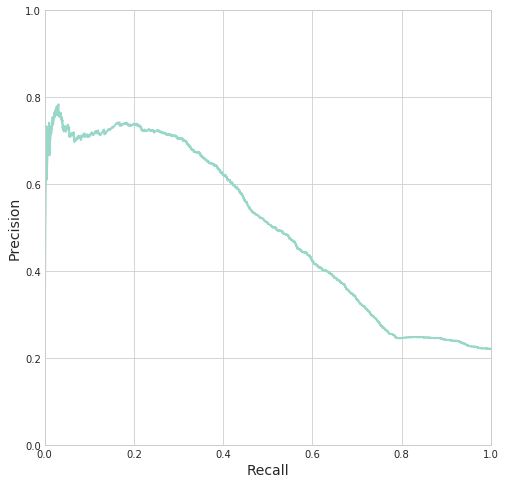

In [165]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(recalls[0], precisions[0], lw=2)
    ax.set_ylabel('Precision', fontsize=14)
    ax.set_xlabel('Recall', fontsize=14)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

C:\Users\mattt\Anaconda3\envs\tf15\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\mattt\Anaconda3\envs\tf15\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\mattt\Anaconda3\envs\tf15\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\mattt\Anaconda3\envs\tf15\lib\site-packages\matplotlib\__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


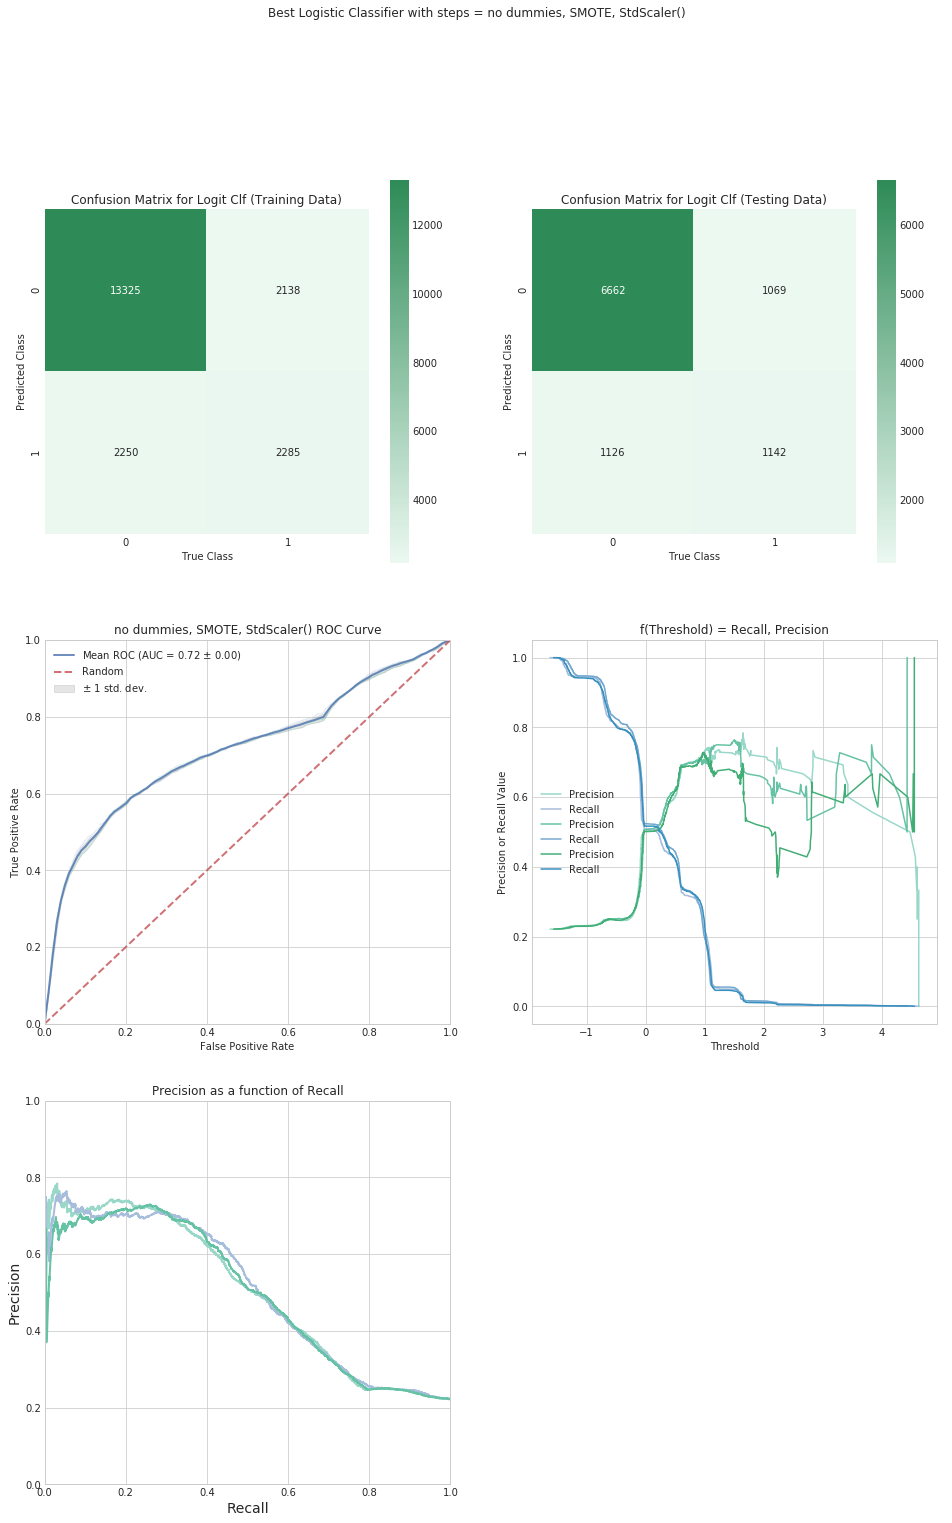

In [171]:
evaluator_2(best_logit_sm_ss_pipe_clf, cc_df, cc_classes, 
            'Logistic Classifier', 'no dummies, SMOTE, StdScaler()',
                cv_runs_=3, labels=[0,1], thresh=0.5)

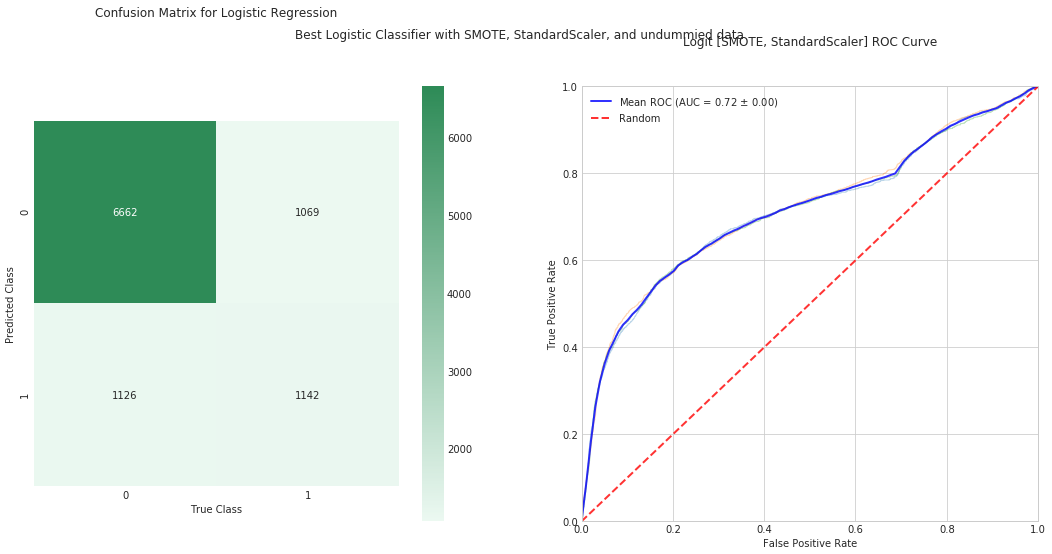

In [43]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18,8))
    fig.suptitle('Best Logistic Classifier with SMOTE, StandardScaler,'+
                 ' and undummied data')
    hb_roc(ax[1], fprs, tprs, threshs, 'Logit [SMOTE, StandardScaler]')
    confusion_mat_plotter(ax[0], avg_cfn, [0,1], 'for Logistic Regression')

In [87]:

cv_runs = 3
clf_ = best_logit_sm_ss_pipe_clf
skfolds = StratifiedKFold(n_splits=cv_runs, random_state=nb_seed, shuffle=True)
data_cols = cc_df.columns
class_col = cc_classes.name
data_ = np.array(cc_df.reset_index(drop=True))
classes_ = np.array(cc_classes.reset_index(drop=True))
thresh=0.5
labels = [0,1]
fold_obvs = np.trunc(len(data_)/cv_runs)

cfns = np.zeros((cv_runs,2,2))
fprs = []; tprs = []; threshs = []
precisions = [] # I wanted to abbreviate this variable name, but it's too similar to preds
recalls = []; pr_threshs = []
train_preds = np.zeros((cv_runs,int(fold_obvs)))
test_preds = np.zeros((cv_runs,int(fold_obvs)))
probas = np.zeros((cv_runs,int(fold_obvs)))
i=0
for train_inds, test_inds in skfolds.split(data_, classes_):
    clone_clf = clone(clf_)
    data_train_fold = data_[train_inds]
    class_train_fold = classes_[train_inds]
    data_test_fold = data_[test_inds]
    class_test_fold = classes_[test_inds]

    clone_clf.fit(data_train_fold, class_train_fold)
    probas[i] = np.array(clone_clf.predict_proba(data_test_fold)[:,1], dtype=object)
    test_preds[i] = np.array(clone_clf.predict(data_test_fold), dtype=object)
    train_preds = np.array(clone_clf.predict(data_train_fold), dtype=object)
    cfns[i] = confusion_matrix(class_test_fold, test_preds[i], labels)
    fpr, tpr, thresh = roc_curve(class_test_fold, probas[i, :])  
    fprs.append(fpr); tprs.append(tpr); threshs.append(thresh)
    
    cfns[i] = confusion_matrix(class_test_fold, test_preds[i], labels)
    class_scores = clone_clf.decision_function(data_test_fold)
    p, r, pr_thr = precision_recall_curve(class_test_fold, class_scores)
    precisions.append(p); recalls.append(r); pr_threshs.append(pr_thr)
    i += 1
    
# avg_cfn = cfns//i
#     print('r.shape: {}'.format(r.shape))
#     print('clone_clf.decision_function(data_test_fold): {}'
#           .format(clone_clf.decision_function(data_train_fold)))
#     print('clone_clf.decision_function(data_test_fold).shape {}'
#           .format(clone_clf.decision_function(data_test_fold).shape))    

C:\Users\mattt\Anaconda3\envs\tf15\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


r.shape: (9629,)
clone_clf.decision_function(data_test_fold): [-0.53010088 -0.10197772 -0.09005273 ... -0.72313162  2.23017536
  0.20846325]
clone_clf.decision_function(data_test_fold).shape (10000,)


C:\Users\mattt\Anaconda3\envs\tf15\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


r.shape: (9652,)
clone_clf.decision_function(data_test_fold): [ 1.1021887  -0.06113164 -0.53140328 ... -0.65874769  0.08915196
 -0.0570263 ]
clone_clf.decision_function(data_test_fold).shape (10000,)
r.shape: (9531,)
clone_clf.decision_function(data_test_fold): [ 1.09283306 -0.5484689  -0.0839138  ... -0.19654287  2.22446361
 -0.06777354]
clone_clf.decision_function(data_test_fold).shape (10000,)


C:\Users\mattt\Anaconda3\envs\tf15\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [69]:
sns.color_palette()

[(0.9294117647058824, 0.9725490196078431, 0.984313725490196),
 (0.6980392156862745, 0.8862745098039215, 0.8862745098039215),
 (0.4, 0.7607843137254902, 0.6431372549019608),
 (0.17254901960784313, 0.6352941176470588, 0.37254901960784315),
 (0.0, 0.42745098039215684, 0.17254901960784313)]

array([[6662, 1126],
       [1069, 1142]])

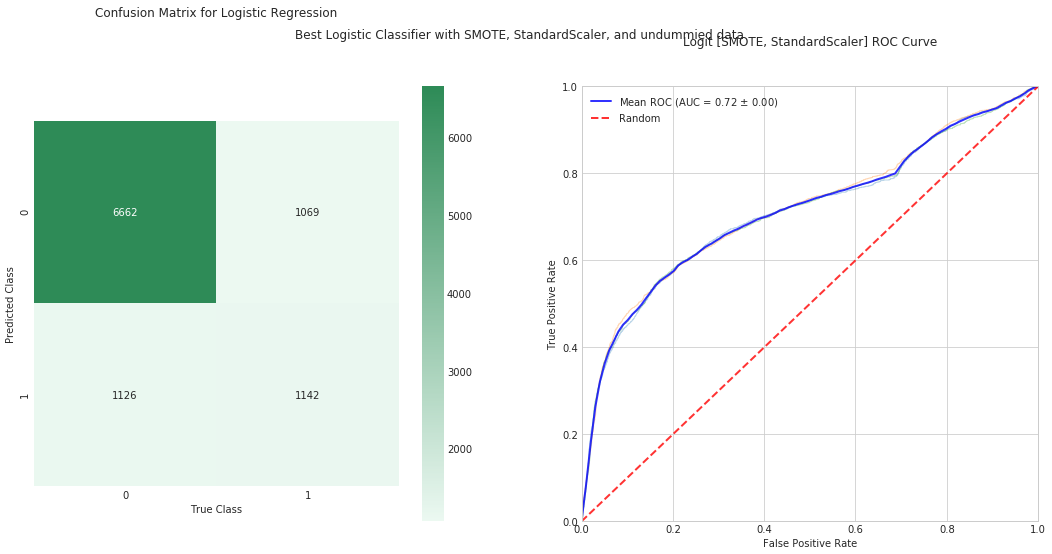

In [43]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18,8))
    fig.suptitle('Best Logistic Classifier with SMOTE, StandardScaler,'+
                 ' and undummied data')
    hb_roc(ax[1], fprs, tprs, threshs, 'Logit [SMOTE, StandardScaler]')
    confusion_mat_plotter(ax[0], avg_cfn, [0,1], 'for Logistic Regression')

In [35]:
# threshs[1].shape
fpr.shape
tmp = []
tmp.append(probas)
tmp
# train_inds[:int(fold_obvs)]
# np.trunc(len(data_)/4)
# tprs[1].shape

# np.zeros((cv_runs,int(fold_obvs)))
# type(classes_)
# train_inds
# cfns = np.zeros(shape=(cv_runs,2,2))
# cfns[1] = [[1,2],[3,4]]
# cfns

[array([[0.74249201, 0.40062236, 0.48157929, ..., 0.45184316, 0.45423023,
         0.4774396 ],
        [0.3846868 , 0.48234218, 0.4857938 , ..., 0.46810039, 0.82095071,
         0.89704681],
        [0.48209373, 0.28833353, 0.4556656 , ..., 0.74337381, 0.33329928,
         0.54936565]])]

In [27]:
def evaluator(clf_, data_, labels_,  clf_type, cv_runs_=30,
              seed=1234, debugger = False, plot_thresh=False):
    tprs = []
    aucs = []
    cfns = np.zeros((2,2), dtype=int)
    mean_fpr = np.linspace(0, 1, 100)
    rng = np.random.RandomState(seed)
    random_seeds = rng.randint(low=0, high=99999, size=cv_runs_)
#     robust_scaler = RobustScaler()
    with plt.style.context('seaborn-whitegrid'):
        fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(14,7))
    if plot_thresh:
        ax_thresh = ax[1].twinx()
        ax_thresh.set_xlim([0,1])
        ax_thresh.set_ylim([0,1])
        ax_thresh_y = ax[1].twiny()
        ax_thresh_y.set_xlabel('Threshold: True Positive Rate', color='r',
                              fontsize=8)
    
    for i in range(cv_runs_):
        d_train, d_test, cls_train, cls_test = \
                    train_test_split(data_, labels_, random_state=random_seeds[i])
        d_train_sm, cls_train_sm = sm.fit_sample(d_train, cls_train)
        d_test_sm, cls_test_sm = sm.fit_sample(d_test, cls_test)
#         if scale_data:
#             d_train_sm = robust_scaler.fit_transform(d_train_sm)
#             d_test_sm = robust_scaler.transform(d_test_sm)
        probas_ = clf_.fit(d_train_sm, cls_train_sm).predict_proba(d_test_sm)
        preds_ = clf_.predict(d_test_sm)
        cfn_ = confusion_matrix(cls_test_sm, preds_, [0,1])
        cfns = cfns + cfn_
        fpr, tpr, thresholds = roc_curve(cls_test_sm, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0 
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
#         l_label = 'ROC for cv run {:d} (AUC = {:0.2f})'.format(i, roc_auc)
        ax[1].plot(fpr, tpr, lw=1, alpha=0.3)
        if plot_thresh:
            ax_thresh.plot(tpr[1:], thresholds[1:], linestyle='dashed', alpha=0.3, lw=0.7)
    
    # Plotting the average Confusion Matrix
    cfns = cfns//i
    cfn_title = 'Averaged Confusion Matrix for {} Clf'.format(clf_type)
    confusion_mat_plotter(ax[0], cfns, [0,1], cfn_title)
    
    # Plotting the error bars on the ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax[1].plot(mean_fpr, mean_tpr, color='b',
            label='Mean ROC (AUC = {:0.2f} $\pm$ {:0.2f})'
               .format(mean_auc, std_auc), lw=2, alpha=0.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax[1].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', 
                     alpha=.2, label='$\pm$ 1 std. dev.')
    ax[1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', 
               label='Random', alpha=.8)
    ax[1].legend(loc='best', fancybox=True, framealpha=0.4)
#     ax[1].legend(loc=(1.03, 0), fancybox=True, framealpha=0.4)
    ax[1].set_title('{} ROC Curve'.format(clf_type), y=1.08)
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_xlim([0.0,1.0])
    ax[1].set_ylim([0.0,1.0])
    if plot_thresh:
        ax_thresh.set_ylabel('Threshold', color='r')

In [36]:
logit_df = print_logit_stats(logit_clf_grid)
logit_df.head(5)

Param values that produces the most accurate model: {'logit_clf__max_iter': 100, 'logit_clf__C': 1000, 'logit_clf__penalty': 'l1', 'logit_clf__solver': 'liblinear'}
Score of the most accurate model: 0.779467 



KeyError: 'param_C'

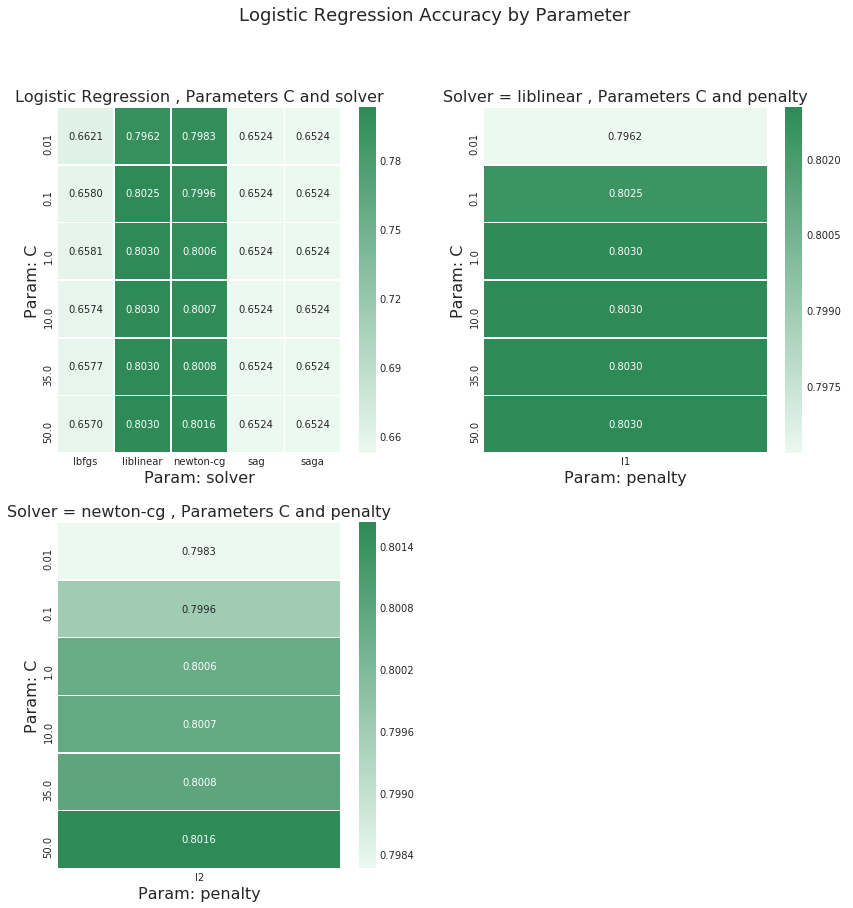

In [28]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=(14,14))
    fig.suptitle('Logistic Regression Accuracy by Parameter', fontsize=18)
    ax = ax.flatten()
    param_heat_mapper(ax[0], logit_df, 'C', 'mean score', 'solver',
                      'Logistic Regression', cmap=g_cmap)
    param_heat_mapper(ax[1], logit_df[logit_df['solver'] == 'liblinear'], 'C',
                  'mean score', 'penalty', 'Solver = liblinear', cmap=g_cmap)
    param_heat_mapper(ax[2], logit_df[logit_df['solver'] == 'newton-cg'], 'C',
                  'mean score', 'penalty', 'Solver = newton-cg', cmap=g_cmap)
    ax[3].axis('off')

In [14]:
%xmode Verbose

Exception reporting mode: Verbose


In [75]:
best_logit_clf = LogisticRegression(solver='liblinear', penalty='l1',
                                   C=1, max_iter=100)

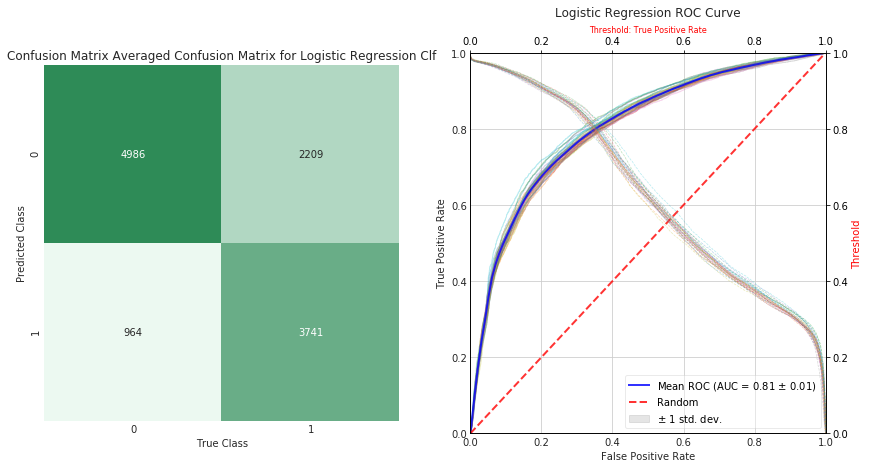

In [112]:
evaluator(best_logit_clf, cc_cats, cc_classes, 'Logistic Regression',
          30, plot_thresh=True)

In [77]:
metric_printer(4991,2227,959,3723, 'Logistic Regression', 'SMOTE-Balanced data')

Metrics for the best SMOTE-Balanced data trained Logistic Regression
- Overall Accuracy:                 0.7323
- True Positive Rate (sensitivity): 0.6257
- True Negative Rate (specificity): 0.8388
- Precision (recall):               0.7952
- False Positive Rate:              0.1612
- F-measure:                        0.7003


## KNN

Now I'll try build to build a reasonably well tuned K-Nearest Neighbors classifier to see how it performs on this data. As KNN uses a distance metric, we'll want to scale the data, but I'll establish a baseline with the unscaled SMOTE-balanced data.

In [110]:
knn_param = [
                {'n_neighbors': [3,5,10,20],
                 'p': [1,2,2.5,3]
                }
            ]
knn_clf = KNeighborsClassifier()

In [111]:
knn_clf_grid = GridSearchCV(knn_clf, knn_param, verbose=9, cv=3,
                            n_jobs=-1, return_train_score=True)

%time knn_clf_grid.fit(cc_train_sm, class_train_sm)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  39 out of  48 | elapsed:  3.4min remaining:   46.8s
[Parallel(n_jobs=-1)]: Done  45 out of  48 | elapsed:  4.5min remaining:   18.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  4.6min finished


Wall time: 4min 38s


GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_neighbors': [3, 5, 10, 20], 'p': [1, 2, 2.5, 3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=9)

In [116]:
print_stats(knn_clf_grid)

Param values that produces the most accurate model: {'n_neighbors': 3, 'p': 1}
Score of the most accurate model: 0.768860 

   --- Mean accuracy (+/- standard deviation) for different C values ---
0.769 (+/- 0.009) for the model with params {'n_neighbors': 3, 'p': 1}
0.762 (+/- 0.008) for the model with params {'n_neighbors': 3, 'p': 2}
0.758 (+/- 0.007) for the model with params {'n_neighbors': 3, 'p': 2.5}
0.756 (+/- 0.006) for the model with params {'n_neighbors': 3, 'p': 3}
0.742 (+/- 0.010) for the model with params {'n_neighbors': 5, 'p': 1}
0.735 (+/- 0.010) for the model with params {'n_neighbors': 5, 'p': 2}
0.731 (+/- 0.012) for the model with params {'n_neighbors': 5, 'p': 2.5}
0.730 (+/- 0.013) for the model with params {'n_neighbors': 5, 'p': 3}
0.709 (+/- 0.016) for the model with params {'n_neighbors': 10, 'p': 1}
0.704 (+/- 0.015) for the model with params {'n_neighbors': 10, 'p': 2}
0.703 (+/- 0.014) for the model with params {'n_neighbors': 10, 'p': 2.5}
0.702 (+/- 0.

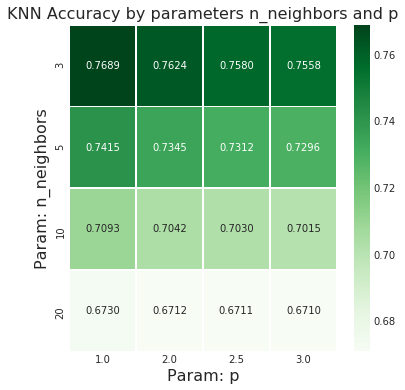

In [129]:
clf_dict = knn_clf_grid
knn_dict = {
    'mean score': clf_dict.cv_results_['mean_test_score'],
    'n_neighbors': clf_dict.cv_results_['param_n_neighbors'],
    'p': clf_dict.cv_results_['param_p']
}
knn_df = pd.DataFrame(knn_dict)
clf_df = knn_df
clf_name = 'KNN'
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, figsize=(6,6))
#     ax = ax.flatten()
    param_heat_mapper(ax, clf_df, 'n_neighbors', 'mean score', 'p', clf_name)
    

Hmm, $0.7688$ isn't very encouraging. Let's scale the data and try again.  

In [60]:
rs = RobustScaler()
cc_train_sm_rs = rs.fit_transform(cc_train_sm)

In [23]:
knn_param = [
                {'n_neighbors': [1,2,3],
                 'p': [1,2]
                }
            ]
knn_clf = KNeighborsClassifier()

In [24]:
knn_clf_grid = GridSearchCV(knn_clf, knn_param, verbose=9, cv=3, n_jobs=-1)

%time knn_clf_grid.fit(cc_train_sm_rs, class_train_sm)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done   6 out of  18 | elapsed:  1.1min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:  2.6min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  12 out of  18 | elapsed:  3.3min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  4.2min remaining:   50.3s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  4.5min finished


Wall time: 4min 30s


GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'p': [1, 2], 'n_neighbors': [1, 2, 3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=9)

In [54]:
knn_param = [
                {'n_neighbors': [1,2,3],
                 'p': [1,2]
                }
            ]
knn_clf = KNeighborsClassifier()

In [55]:
knn_clf_grid = GridSearchCV(knn_clf, knn_param, verbose=9, cv=3, n_jobs=-1)

%time knn_clf_grid.fit(cc_train_sm_rs, class_train_sm)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done   6 out of  18 | elapsed:  1.0min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:  2.9min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  12 out of  18 | elapsed:  3.8min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  4.9min remaining:   58.5s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  5.3min finished


Wall time: 5min 19s


GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'p': [1, 2], 'n_neighbors': [1, 2, 3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=9)

In [56]:
print_stats(knn_clf_grid)

Param values that produces the most accurate model: {'p': 1, 'n_neighbors': 1}
Score of the most accurate model: 0.859030 

   --- Mean accuracy (+/- standard deviation) for different parameters ---
0.859 (+/- 0.020) for the model with params {'p': 1, 'n_neighbors': 1}
0.841 (+/- 0.024) for the model with params {'p': 2, 'n_neighbors': 1}
0.826 (+/- 0.058) for the model with params {'p': 1, 'n_neighbors': 2}
0.817 (+/- 0.045) for the model with params {'p': 2, 'n_neighbors': 2}
0.824 (+/- 0.033) for the model with params {'p': 1, 'n_neighbors': 3}
0.798 (+/- 0.024) for the model with params {'p': 2, 'n_neighbors': 3}


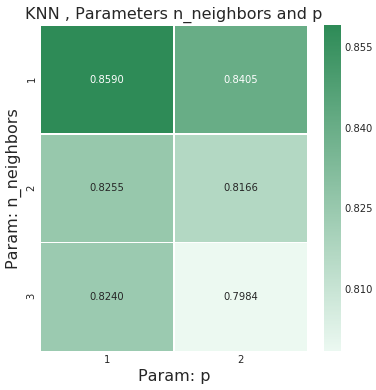

In [57]:
clf_dict = knn_clf_grid
knn_dict = {
    'mean score': clf_dict.cv_results_['mean_test_score'],
    'n_neighbors': clf_dict.cv_results_['param_n_neighbors'],
    'p': clf_dict.cv_results_['param_p']
}
knn_df = pd.DataFrame(knn_dict)
clf_df = knn_df
clf_name = 'KNN'
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, figsize=(6,6))
    param_heat_mapper(ax, clf_df, 'n_neighbors', 'mean score', 'p', clf_name)

Ok, an accuracy of $0.8590$ is more encouraging. 

In [56]:
cc_cats.shape
cc_classes.shape
cc_cats_rs.shape

(29601, 87)

In [89]:
cc_cats_rs = pd.DataFrame(rs.fit_transform(cc_cats), columns=cc_cats.columns)
cc_cats_rs.head(5)

LIMIT_BAL       AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0  -0.631579 -0.769231  -0.290768  -0.296529  -0.338347  -0.365889  -0.374617   
1  -0.105263 -0.615385  -0.310278  -0.319279  -0.303491  -0.302896  -0.303073   
2  -0.263158  0.000000   0.110627  -0.116031  -0.113260  -0.089985  -0.065083   
3  -0.473684  0.230769   0.391964   0.449105   0.511665   0.179219   0.225048   
4  -0.473684  1.769231  -0.216214  -0.254101   0.276330   0.037253   0.021846   

   BILL_AMT6  PAY_AMT1  PAY_AMT2   ...     PAY_6_-2  PAY_6_-1  PAY_6_0  \
0  -0.357795 -0.524345 -0.315689   ...          1.0       0.0     -1.0   
1  -0.289635 -0.524345 -0.241198   ...          0.0       0.0     -1.0   
2  -0.032795 -0.145318 -0.121437   ...          0.0       0.0      0.0   
3   0.259787 -0.024969  0.002874   ...          0.0       0.0      0.0   
4   0.042075 -0.024969  8.305150   ...          0.0       0.0      0.0   

   PAY_6_2  PAY_6_3  PAY_6_4  PAY_6_5  PAY_6_6  PAY_6_7  PAY_6_8  
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
1      1.0      0.0      0.0      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
3      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
4      0.0      0.0      0.0      0.0      0.0      0.0      0.0  

[5 rows x 87 columns]

In [90]:
best_knn_clf = KNeighborsClassifier(p=1, n_neighbors=1, n_jobs=-1)

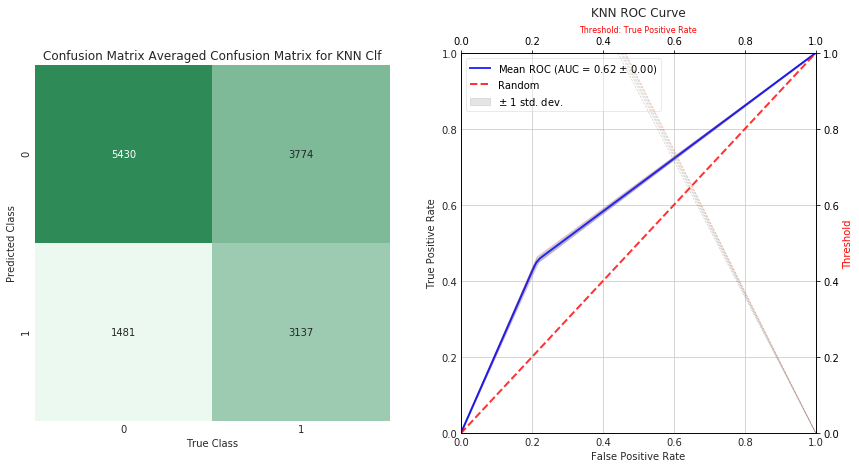

In [113]:
evaluator(best_knn_clf, cc_cats_rs, cc_classes, 'KNN', 6, plot_thresh=True)

In [78]:
metric_printer(6779,4723,1868,3924, 'KNN', 'SMOTE-Balanced, RobustScaled data')

Metrics for the best SMOTE-Balanced, RobustScaled data trained KNN
- Overall Accuracy:                 0.6189
- True Positive Rate (sensitivity): 0.4538
- True Negative Rate (specificity): 0.7840
- Precision (recall):               0.6775
- False Positive Rate:              0.2160
- F-measure:                        0.5435


### KNN Analysis: 

Hmm, this produced an accuracy far below what I was expecting from my preliminary run, although that was performed only with 3 folds on about $\frac{2}{3}$ of the data (although it was enlarged via SMOTE). Also, the order of SMOTE and scaling was altered. Time permitting, I  might investigate the effect of using an undersampling balancing technique like **Tomek** coupled with SMOTE$^{bib1}$.

## Random Forest:



In [70]:
rf_param = [
                {
                    'criterion': ['entropy', 'gini'],
                    'n_estimators': [50,100],
                    'max_depth': [3,5,10,15],
                    'max_features': [10,20,30],
                    'min_samples_leaf': [1,3],
                    'min_samples_split': [2,5]
                }
            ]
rf_clf = RandomForestClassifier()

In [73]:
rf_clf_grid = GridSearchCV(rf_clf, rf_param, verbose=9, cv=5, n_jobs=-1)

%time rf_clf_grid.fit(cc_train_sm, class_train_sm)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  6.5min
[Paralle

Wall time: 9min 32s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'criterion': ['entropy', 'gini'], 'n_estimators': [50, 100], 'max_depth': [3, 5, 10, 15], 'min_samples_leaf': [1, 3], 'max_features': [10, 20, 30], 'min_samples_split': [2, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=9)

In [87]:
best_rf_clf_grid = rf_clf_grid

In [88]:
rf_clf_grid = GridSearchCV(rf_clf, rf_param, verbose=9, cv=2, n_jobs=-1)

%time rf_clf_grid.fit(cc_train_sm, class_train_sm)

Fitting 2 folds for each of 192 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:  5.5min finished


Wall time: 5min 37s


GridSearchCV(cv=2, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'criterion': ['entropy', 'gini'], 'n_estimators': [50, 100], 'max_depth': [3, 5, 10, 15], 'min_samples_leaf': [1, 3], 'max_features': [10, 20, 30], 'min_samples_split': [2, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=9)

In [89]:
rf_clf_grid.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [93]:
display(cc_train_sm.shape)
display(cc_test_sm.shape)
display(class_train_sm.shape)
display(class_test_sm.shape)
cc_train_sm.head(5)

(30276, 87)

(15716, 87)

(30276,)

(15716, 1)

LIMIT_BAL   AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0    10000.0  26.0     8882.0     9933.0     9825.0    17506.0    16608.0   
1   120000.0  42.0    23331.0    12125.0    13903.0    13858.0    14777.0   
2   350000.0  36.0    21026.0    35588.0    38002.0    40357.0    43663.0   
3    60000.0  45.0    58360.0    56834.0    58322.0    59781.0     8177.0   
4    50000.0  23.0    41740.0    42755.0    43878.0    42877.0    45701.0   

   BILL_AMT6  PAY_AMT1  PAY_AMT2   ...     PAY_6_-2  PAY_6_-1  PAY_6_0  \
0     9176.0    1300.0    2200.0   ...          0.0       0.0      1.0   
1    46061.0    5000.0    5000.0   ...          0.0       0.0      1.0   
2    52735.0   15000.0    3000.0   ...          0.0       0.0      1.0   
3     7757.0       0.0    3000.0   ...          0.0       0.0      1.0   
4    46720.0    2000.0    2100.0   ...          0.0       0.0      0.0   

   PAY_6_2  PAY_6_3  PAY_6_4  PAY_6_5  PAY_6_6  PAY_6_7  PAY_6_8  
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
3      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
4      1.0      0.0      0.0      0.0      0.0      0.0      0.0  

[5 rows x 87 columns]

In [78]:
print_stats(rf_clf_grid, False)

Param values that produces the most accurate model: {'criterion': 'entropy', 'min_samples_leaf': 1, 'max_depth': 3, 'n_estimators': 50, 'max_features': 20, 'min_samples_split': 2}
Score of the most accurate model: 1.000000 



In [114]:
best_rf_clf = RandomForestClassifier(criterion='gini', max_depth=15,
                                     min_samples_leaf=1, min_samples_split=5,
                                     n_estimators=100, max_features=10,
                                     n_jobs=-1)

In [95]:
rf_smell_test = best_rf_clf.fit(cc_train_sm, class_train_sm)
rf_smell_preds = rf_smell_test.predict(cc_test_sm)
accuracy_score(class_test_sm, rf_smell_preds)


0.8771952150674472

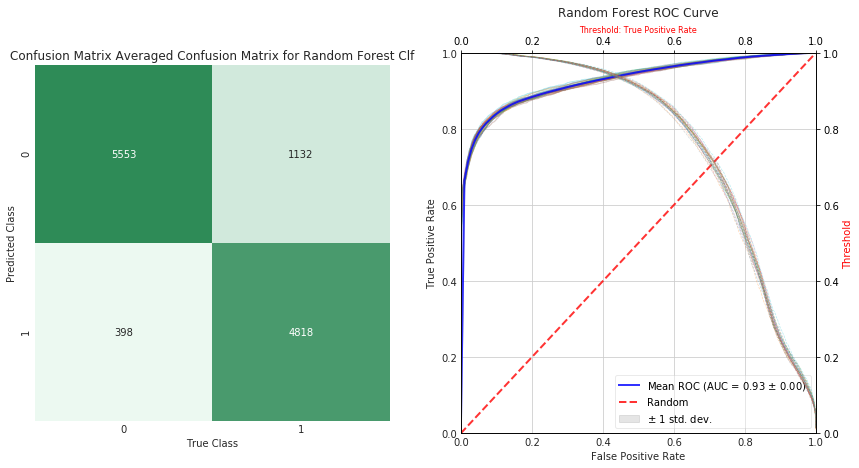

In [115]:
evaluator(best_rf_clf, cc_cats, cc_classes, 'Random Forest', 30, plot_thresh=True)

In [79]:
metric_printer(5553,1131,397,4820, 'Random Forest', 'SMOTE-Balanced')

Metrics for the best SMOTE-Balanced trained Random Forest
- Overall Accuracy:                 0.8716
- True Positive Rate (sensitivity): 0.8099
- True Negative Rate (specificity): 0.9333
- Precision (recall):               0.9239
- False Positive Rate:              0.0667
- F-measure:                        0.8632


## Explicitly using BAgging to build a RandomForest

In [59]:
ba_dt_param = [
                {
                    'base_estimator__criterion': ['entropy', 'gini'],
                    'base_estimator__max_depth': [7,15],
                    'base_estimator__min_samples_leaf': [1],
                    'base_estimator__min_samples_split': [2,6],
                    'n_estimators': [50,100],
                    'max_samples': [30,50]
                }
            ]
ba_dt_clf = BaggingClassifier(DecisionTreeClassifier())

In [60]:
ba_dt_clf_grid = GridSearchCV(ba_dt_clf, ba_dt_param, verbose=9, cv=3, n_jobs=-1)

%time ba_dt_clf_grid.fit(cc_train_sm, class_train_sm)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  92 out of  96 | elapsed:  5.4min remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  5.5min finished


Wall time: 5min 38s


GridSearchCV(cv=3, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            ...n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'base_estimator__min_samples_split': [2, 6], 'base_estimator__min_samples_leaf': [1], 'base_estimator__max_depth': [7, 15], 'max_samples': [30, 50], 'base_estimator__criterion': ['entropy', 'gini'], 'n_estimators': [50, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=9)

In [63]:
clf_dict = ba_dt_clf_grid
ba_dt_dict = {
    'mean score': clf_dict.cv_results_['mean_test_score'],
    'criterion': clf_dict.cv_results_['param_base_estimator__criterion'],
    'max_samples': clf_dict.cv_results_['param_max_samples'],
    'min_samples_leaf': clf_dict.cv_results_['param_base_estimator__min_samples_leaf'],
    'min_samples_split': clf_dict.cv_results_['param_base_estimator__min_samples_split'],
    'max_depth': clf_dict.cv_results_['param_base_estimator__max_depth'],
    'param_n_estimators': clf_dict.cv_results_['param_n_estimators']
}
ba_dt_df = pd.DataFrame(ba_dt_dict)
clf_df = ba_dt_df
clf_df.sort_values(['mean score'], ascending=False).head(10)

criterion max_depth max_samples  mean score min_samples_leaf  \
3    entropy         7          50    0.780090                1   
15   entropy        15          50    0.779528                1   
23      gini         7          50    0.778438                1   
19      gini         7          50    0.777679                1   
11   entropy        15          50    0.774739                1   
27      gini        15          50    0.774343                1   
7    entropy         7          50    0.774277                1   
31      gini        15          50    0.772691                1   
6    entropy         7          50    0.772229                1   
26      gini        15          50    0.772097                1   

   min_samples_split param_n_estimators  
3                  2                100  
15                 6                100  
23                 6                100  
19                 2                100  
11                 2                100  
27                 2                100  
7                  6                100  
31                 6                100  
6                  6                 50  
26                 2                 50

In [21]:
ba_dt_clf_grid.best_params_

{'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 7,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 6,
 'max_samples': 30,
 'n_estimators': 100}

In [55]:
ba_dt_param = [
                {
                    'base_estimator__criterion': ['entropy', 'gini'],
                    'base_estimator__max_depth': [15,30,45],
                    'base_estimator__min_samples_leaf': [1],
                    'base_estimator__min_samples_split': [2,6],
                    'n_estimators': [50,100],
                    'max_samples': [0.25, 0.5]
                }
            ]
ba_dt_clf = BaggingClassifier(DecisionTreeClassifier())

In [56]:
ba_dt_clf_grid = GridSearchCV(ba_dt_clf, ba_dt_param, verbose=9, cv=2, n_jobs=-1)

%time ba_dt_clf_grid.fit(cc_train_sm, class_train_sm)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  92 out of  96 | elapsed:  6.5min remaining:   16.8s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  6.7min finished


Wall time: 7min 11s


GridSearchCV(cv=2, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            ...n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'base_estimator__criterion': ['entropy', 'gini'], 'max_samples': [0.25, 0.5], 'base_estimator__min_samples_leaf': [1], 'n_estimators': [50, 100], 'base_estimator__max_depth': [15, 30, 45], 'base_estimator__min_samples_split': [2, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=9)

In [57]:
clf_dict = ba_dt_clf_grid
ba_dt_dict = {
    'mean score': clf_dict.cv_results_['mean_test_score'],
    'criterion': clf_dict.cv_results_['param_base_estimator__criterion'],
    'max_samples': clf_dict.cv_results_['param_max_samples'],
    'min_samples_leaf': clf_dict.cv_results_['param_base_estimator__min_samples_leaf'],
    'min_samples_split': clf_dict.cv_results_['param_base_estimator__min_samples_split'],
    'max_depth': clf_dict.cv_results_['param_base_estimator__max_depth'],
    'param_n_estimators': clf_dict.cv_results_['param_n_estimators']
}
ba_dt_df = pd.DataFrame(ba_dt_dict)
clf_df = ba_dt_df
clf_df.sort_values(['mean score'], ascending=False).head(10)

criterion max_depth max_samples  mean score min_samples_leaf  \
43      gini        45         0.5    0.827817                1   
34      gini        30         0.5    0.826926                1   
35      gini        30         0.5    0.826331                1   
39      gini        30         0.5    0.825770                1   
47      gini        45         0.5    0.825571                1   
17   entropy        45        0.25    0.825472                1   
11   entropy        30         0.5    0.825406                1   
19   entropy        45         0.5    0.825208                1   
32      gini        30        0.25    0.825175                1   
40      gini        45        0.25    0.825076                1   
46      gini        45         0.5    0.825076                1   
23   entropy        45         0.5    0.825076                1   
33      gini        30        0.25    0.825010                1   
45      gini        45        0.25    0.824911                1   
41      gini        45        0.25    0.824415                1   
42      gini        45         0.5    0.824250                1   
36      gini        30        0.25    0.824184                1   
37      gini        30        0.25    0.824118                1   
15   entropy        30         0.5    0.823953                1   
38      gini        30         0.5    0.823722                1   
21   entropy        45        0.25    0.823557                1   
22   entropy        45         0.5    0.823325                1   
14   entropy        30         0.5    0.823325                1   
20   entropy        45        0.25    0.823325                1   
27      gini        15         0.5    0.823193                1   
30      gini        15         0.5    0.823160                1   
31      gini        15         0.5    0.823127                1   
18   entropy        45         0.5    0.822929                1   
29      gini        15        0.25    0.822896                1   
0    entropy        15        0.25    0.822599                1   
9    entropy        30        0.25    0.822037                1   
25      gini        15        0.25    0.821905                1   
13   entropy        30        0.25    0.821905                1   
2    entropy        15         0.5    0.821608                1   
10   entropy        30         0.5    0.821212                1   
5    entropy        15        0.25    0.821145                1   
44      gini        45        0.25    0.820947                1   
4    entropy        15        0.25    0.820650                1   
1    entropy        15        0.25    0.820518                1   
16   entropy        45        0.25    0.820287                1   
3    entropy        15         0.5    0.820055                1   
28      gini        15        0.25    0.819956                1   
7    entropy        15         0.5    0.819758                1   
8    entropy        30        0.25    0.819593                1   
12   entropy        30        0.25    0.819362                1   
6    entropy        15         0.5    0.819329                1   
26      gini        15         0.5    0.819263                1   
24      gini        15        0.25    0.818569                1   

   min_samples_split param_n_estimators  
43                 2                100  
34                 2                 50  
35                 2                100  
39                 6                100  
47                 6                100  
17                 2                100  
11                 2                100  
19                 2                100  
32                 2                 50  
40                 2                 50  
46                 6                 50  
23                 6                100  
33                 2                100  
45                 6                100  
41                 2                100  
42                 2                 50  
36   

In [54]:
ba_dt_clf_grid.best_params_

{'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 15,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 6,
 'max_samples': 0.25,
 'n_estimators': 50}

In [116]:
best_ba_dt_clf = BaggingClassifier(
                    DecisionTreeClassifier(criterion='gini', max_depth=15,
                                           min_samples_leaf=1, min_samples_split=6),
                    max_samples=0.25, n_estimators=50, n_jobs=-1)

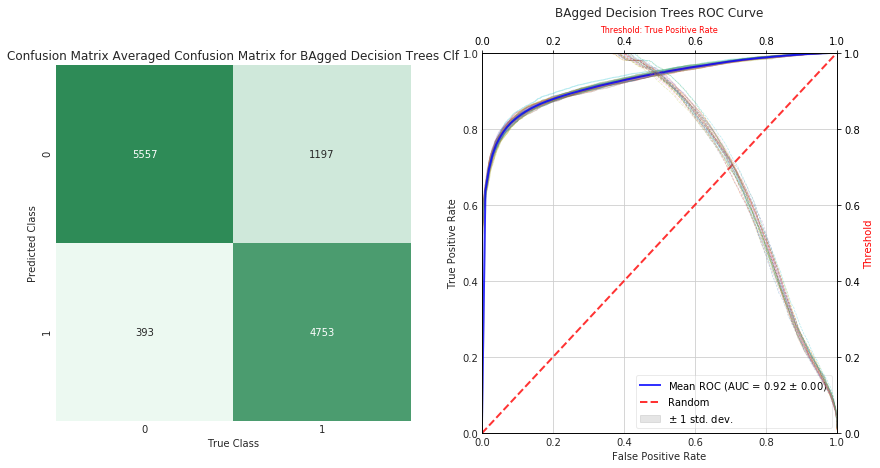

In [117]:
evaluator(best_ba_dt_clf, cc_cats, cc_classes, 'BAgged Decision Trees', 30, plot_thresh=True)

In [119]:
metric_printer(5557,1207,393,4743, 'BAgged DTrees with decision stumps', 'SMOTE-Balanced')

Metrics for the best SMOTE-Balanced trained BAgged DTrees with decision stumps
- Overall Accuracy:                 0.8655
- True Positive Rate (sensitivity): 0.7971
- True Negative Rate (specificity): 0.9339
- Precision (recall):               0.9235
- False Positive Rate:              0.0661
- F-measure:                        0.8557


## AdaBoost

AdaBoost excels at classifying low-noise data, but it is know 

In [42]:
ada_param = [
                {
                    'learning_rate': [0.3, 0.5, 0.7, 0.9],
                    'n_estimators': [100, 200, 300, 400]
                }
            ]
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

In [44]:
ada_clf_grid = GridSearchCV(ada_clf, ada_param, verbose=9, cv=5, n_jobs=-1)

%time ada_clf_grid.fit(cc_train_sm, class_train_sm)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:  9.2min remaining:   44.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  9.8min finished


Wall time: 10min 11s


GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'learning_rate': [0.3, 0.5, 0.7, 0.9], 'n_estimators': [100, 200, 300, 400]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=9)

In [45]:
clf_dict = ada_clf_grid
ada_dict = {
    'mean score': clf_dict.cv_results_['mean_test_score'],
    'learning_rate': clf_dict.cv_results_['param_learning_rate'],
    'n_estimators': clf_dict.cv_results_['param_n_estimators']
}
ada_df = pd.DataFrame(ada_dict)
clf_df = ada_df
clf_df.sort_values(['mean score'], ascending=False).head(10)

learning_rate  mean score n_estimators
5            0.5    0.861904          200
2            0.3    0.861507          300
7            0.5    0.861177          400
6            0.5    0.860979          300
9            0.7    0.860847          200
3            0.3    0.860748          400
13           0.9    0.860682          200
15           0.9    0.860583          400
11           0.7    0.860517          400
14           0.9    0.860517          300

In [99]:
best_ada_clf_sm = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                                    learning_rate=0.5,
                                    n_estimators=200)

In [100]:
ada_smell_test = best_ada_clf_sm.fit(cc_train_sm, class_train_sm)
ada_smell_preds = ada_smell_test.predict(cc_test_sm)
accuracy_score(class_test_sm, ada_smell_preds)

0.876877067956223

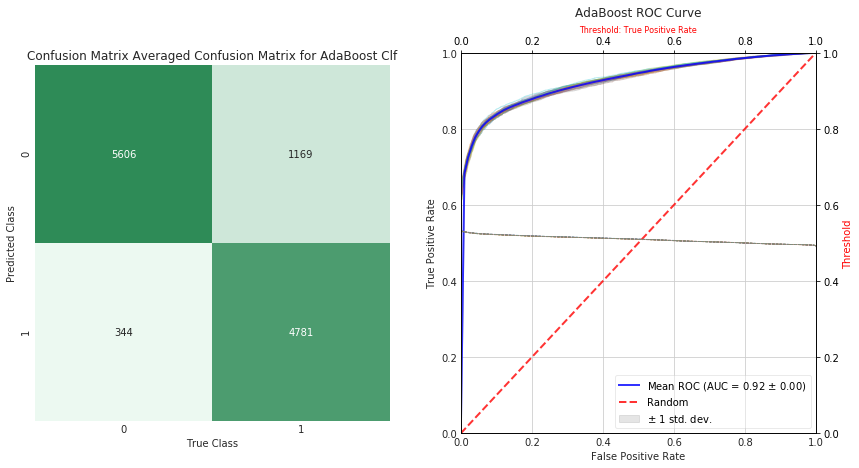

In [118]:
evaluator(best_ada_clf_sm, cc_cats, cc_classes, 'AdaBoost', 30, plot_thresh=True)

In [81]:
metric_printer(5607,1166,343,4785, 'AdaBoost', 'SMOTE-Balanced')

Metrics for the best SMOTE-Balanced trained AdaBoost
- Overall Accuracy:                 0.8732
- True Positive Rate (sensitivity): 0.8041
- True Negative Rate (specificity): 0.9424
- Precision (recall):               0.9331
- False Positive Rate:              0.0576
- F-measure:                        0.8638


In [52]:
best_ada_acc = (5607+4785)/(5607+4785+343+1166)
print('Overall accuracy of the SMOTE-data trained AdaBoost Classifiers: {}'
      .format(best_ada_acc))

Overall accuracy of the SMOTE-data trained AdaBoost Classifiers: 0.8732039324426519


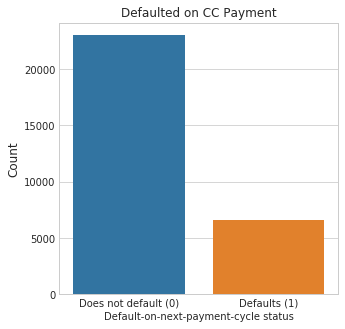

In [124]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(5,5))
#     ax = ax.flatten()
#     fig.suptitle(title)
    sns.countplot(x='default_payment_next_month', data=cc_raw, ax=ax)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xticklabels(['Does not default (0)', 'Defaults (1)'])
    ax.set_xlabel('Default-on-next-payment-cycle status')
    ax.set_title('Defaulted on CC Payment')

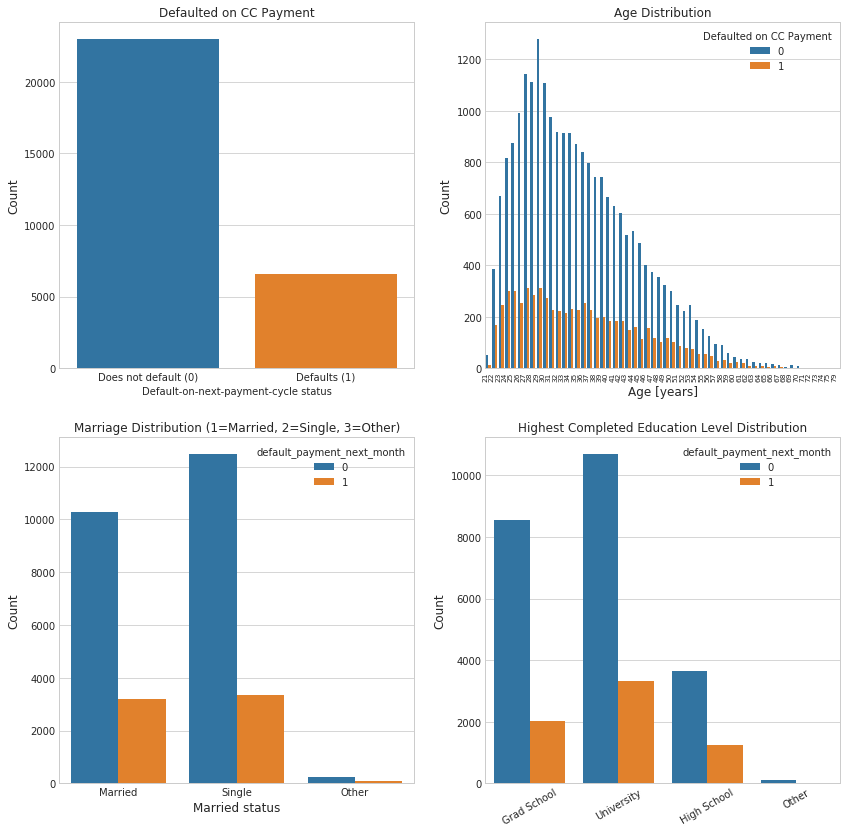

In [127]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(14,14))
    ax = ax.flatten()
#     fig.suptitle(title)
    sns.countplot(x='default_payment_next_month', data=cc_raw, ax=ax[0])
    ax[0].set_ylabel('Count', fontsize=12)
    ax[0].set_xticklabels(['Does not default (0)', 'Defaults (1)'])
    ax[0].set_xlabel('Default-on-next-payment-cycle status')
    ax[0].set_title('Defaulted on CC Payment')
    sns.countplot(x='AGE', data=cc_raw, hue='default_payment_next_month', ax=ax[1])
    ax[1].set_xlabel('Age [years]', fontsize=12)
    ax[1].set_ylabel('Count', fontsize=12)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha='right', fontsize=7.5)
    ax[1].legend(loc='upper right', title='Defaulted on CC Payment')
    ax[1].set_title('Age Distribution')
    sns.countplot(x='MARRIAGE', data=cc_raw, hue='default_payment_next_month', ax=ax[2])
    ax[2].set_xlabel('Married status', fontsize=12)
    ax[2].set_xticklabels(['Married', 'Single', 'Other'])
    ax[2].set_ylabel('Count', fontsize=12)
    ax[2].set_title('Marriage Distribution (1=Married, 2=Single, 3=Other)')
    sns.countplot(x='EDUCATION', data=cc_raw, hue='default_payment_next_month', ax=ax[3])
    ax[3].set_xlabel('', fontsize=12)
    ax[3].set_xticklabels(['Grad School','University','High School','Other'],
                         rotation=30)
    ax[3].set_ylabel('Count', fontsize=12)
    ax[3].set_title('Highest Completed Education Level Distribution') 

In [61]:


def param_heat_mapper(ax_, df_, ind_col, val_col, col_col, base_clfname):
    logit_piv = df_.pivot(index=ind_col, values=val_col, columns=col_col)
    title_ = base_clfname + ' Accuracy by parameters ' + ind_col + ' and ' + col_col
    with plt.style.context('seaborn-whitegrid'):
#         fig, ax = plt.subplots(nrows=1, sharex=False, figsize=(9,7))
        sns.heatmap(logit_piv, linewidths=0.5, annot=True, fmt='0.4f', ax=ax_, cmap=g_cmap)
        ax_.set_title(title_, fontsize=16)
        ax_.set_xlabel('Param: ' + col_col, fontsize=16)
        ax_.set_ylabel('Param: ' + ind_col, fontsize=16)

In [52]:
# help(pickle)
# help(open)
# ax1 = plt.axes()
# help(ax1.xaxis.set_major_locator(plt.MultipleLocator))
# help(plt.MultipleLocator)
# help(plt.LinearLocator)
# help(np.arange)
# help(ax1.xaxis)
# help(sns.countplot)
# help(pd.get_dummies)
# help(fancyimpute)
# help(LogisticRegression)
help(np.empty)

In [ ]:
blues and greebs, sequential
['#99d8c9','#a6bddb','#66c2a4','#74a9cf','#41ae76','#3690c0',
 '#238b45','#0570b0','#006d2c','#045a8d','#00441b','#023858']





Fitting 3 folds for each of 16 candidates, totalling 48 fits
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  39 out of  48 | elapsed:  3.4min remaining:   46.8s
[Parallel(n_jobs=-1)]: Done  45 out of  48 | elapsed:  4.5min remaining:   18.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  4.6min finished
Wall time: 4min 38s
GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_neighbors': [3, 5, 10, 20], 'p': [1, 2, 2.5, 3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=9)



























































# Bibliography


* [bib1] Gustavo E. A. P. A. Batista, Ronaldo C. Prati, and Maria Carolina Monard. "A study of the behavior of several methods for balancing machine learning training data." ACM SIGKDD Explorations Newsletter 6, no. 1 (2004): 20-29. doi:10.1145/1007730.1007735.
* [micebib] Azur, Melissa J., Elizabeth A. Stuart, Constantine Frangakis, and Philip J. Leaf. "Multiple imputation by chained equations: what is it and how does it work?" International Journal of Methods in Psychiatric Research 20, no. 1 (2011): 40-49. doi:10.1002/mpr.329.
* [ROCbib] Fawcett, Tom. "An introduction to ROC analysis." Pattern Recognition Letters 27, no. 8 (December 19, 2005): 861-74. doi:10.1016/j.patrec.2005.10.010.
* [CompareBib] Yeh, I-Cheng, and Che-Hui Lien. "The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients." Expert Systems with Applications 36, no. 2 (2009): 2473-480. doi:10.1016/j.eswa.2007.12.020.

### Presentation/final report format
10 minutes

Slides:
* 1: Title + authors
* 2: Problem Statement and motivativation
* 3+4: related work and what others have done. List papers with results that I want to compare my results to.
* 5-7: Methodology: where data and approach are 
* 8-10: Results
* 11-12: discussion and comparison with related works
* 13: Conclusion and future work (short term and long term)
* 14: references 

Paper:
also include an abstract, intro, and proposal. 

In [32]:
def print_logit_stats(grid_clf, wantPrint=True):
    print('Param values that produces the most accurate model: {}'
          .format(grid_clf.best_params_))
    print('Score of the most accurate model: {:.6f} \n'.format(grid_clf.best_score_))
    means = grid_clf.cv_results_['mean_test_score']
    stdevs = grid_clf.cv_results_['std_test_score']
    params = grid_clf.cv_results_['params']
    c_list = grid_clf.cv_results_['param_C']
    solver_list = grid_clf.cv_results_['param_solver']
    penalty_list = grid_clf.cv_results_['param_penalty']
    dict_ = {
        'mean score': means,
        'mean stdev': stdevs,
        'C': c_list,
        'solver': solver_list,
        'penalty': penalty_list
    }
    if wantPrint:
        print('   --- Mean accuracy (+/- standard deviation) for different C values ---')
    for mean, stdev, c, sol, pen in zip(means, stdevs, c_list, solver_list, penalty_list):
        if wantPrint:
            print('{:0.3f} (+/- {:0.3f}) for the model with C = {:>6.3f}, solver = \
{:10s}, and penalty = {}.'.format(mean, stdev, c, sol, pen))
    return pd.DataFrame(dict_)   
        

        
def print_stats(grid_clf, wantPrint=True):
    print('Param values that produces the most accurate model: {}'
          .format(grid_clf.best_params_))
    print('Score of the most accurate model: {:.6f} \n'.format(grid_clf.best_score_))
    means = grid_clf.cv_results_['mean_test_score']
    stdevs = grid_clf.cv_results_['std_test_score']
    params = grid_clf.cv_results_['params']
    if wantPrint:
        print('   --- Mean accuracy (+/- standard deviation) for different parameters ---')
    for mean, stdev, param in zip(means, stdevs, params):
        if wantPrint:
            print('{:0.3f} (+/- {:0.3f}) for the model with params {}'
                  .format(mean, stdev, param))